# Generalized Linear Models using Pynapple & NeMos
In this notebook, we will use NeMos and Pynapple packages (supported by the [Flatiron Institute](https://neurorse.flatironinstitute.org)), to model spiking neural data using [Generalized Linear Models (GLM)](https://en.wikipedia.org/wiki/Generalized_linear_model). We will explain what GLMs are and which are their components, then use [Pynapple](https://pynapple.org) and [NeMos](https://nemos.readthedocs.io/en/latest/) python packages to preprocess real data from the Primary Visual Cortex (VISp) of mice, and use a GLM model to predict spiking neural data as a function of passive visual stimuli. Moreover, we will also compare this model including an extra predictor: spike history, to assess whether adding history as a predictor improves the performance.

We will be analyzing data from the [Visual Coding - Neuropixels dataset](https://portal.brain-map.org/circuits-behavior/visual-coding-neuropixels), published by the Allen Institute. This dataset uses [extracellular electrophysiology probes](https://www.nature.com/articles/nature24636) to record spikes from multiple regions in the brain during passive visual stimulation. For simplicity, we will focus on the activity of neurons in the visual cortex (VISp) during passive exposure to full-field flashes of color either black (coded as "-1.0") or white (coded as "1.0") in a gray background.

### Background on GLMs


A GLM is a regression model which trains a filter to predict a value (output) as it relates to some other variable (or input). In the neuroscience context, we can use a particular type of GLM to predict spikes: the linear-nonlinear-Poisson (LNP) model. This type of model receives one or more inputs and then sends them through a linear  "filter" or transformation, passes said transformation through a nonlinearity to get the firing rate and uses that firing rate as the mean of a Poisson distribution to generate spikes. 

![LNP model schematic](../../data/images/lnp_model.png)
<p align="center">
LNP model schematic. Modified from <a href="https://www.nature.com/articles/nature07140">Pillow et al., 2008</a>
</p>

1. Sends the inputs through a linear "filter" or transformation
     
    The inputs (also known as "predictors") are first passed through a linear transformation:
    
    $$
    \begin{aligned}
    L(X) = WX + c
    \end{aligned}
    $$

    Where $X$ is the input (in matrix form), $W$ is a matrix and $c$ is a vector (intercept).

    $L$ scales (makes bigger or smaller) or shifts (up or down) the input. When there is zero input, this is equivalent to changing the baseline rate of the neuron, which is how the intercept should be interpreted. So far, this is the same treatment of an ordinary linear regression. 

2. Passes the transformation through a nonlinearity to get the firing rate.
    
    The aim of a LNP model is to predict the firing rate of a neuron and use it to generate spikes, but if we were only to keep $L(X)$ as it is, we would quickly notice that we could obtain negative values for firing rates, which makes no sense! This is what the nonlinearity part of the model handles: by passing the linear transformation through an exponential function, it is assured that the resulting firing rate will always be non-negative. 

    As such, the firing rate in a LNP model is defined:

    $$
    \begin{aligned}
    \lambda =  exp(L(X))
    \end{aligned}
    $$

    where $\lambda$ is a vector containing the firing rates corresponding to each timepoint.

:::{admonition} A note on nonlinearity
:class: info
:class: dropdown


In NeMoS, the nonlinearity is kept fixed. We default to the exponential, but a small number of other choices, such as soft-plus, are allowed. The allowed choices guarantee both the non-negativity constraint described above, as well as convexity, i.e. a single optimal solution. In principle, one could choose a more complex nonlinearity, but convexity is not guaranteed in general.
:::

:::{admonition} What is the difference between a "link function" and the "nonlinearity"?
:class: info
:class: dropdown

The link function states the relationship between the linear predictor and the mean of the distribution function. If $g$ is a link function, $L(⋅)$ is the linear predictor and $\lambda$ the mean of the distribution function:

$$
\begin{aligned}
g(\lambda) = L(⋅)
\end{aligned}
$$

$$
\begin{aligned}
\lambda = g^{-1}(L(⋅))
\end{aligned}
$$

the "nonlinearity" is the name for the inverse of the link function $g^{-1}(⋅)$.

:::

3. Uses the firing rate as the mean of a Poisson distribution to generate spikes

    In this type of GLM, each spike train is modeled as a sample from a Poisson distribution whose mean is the firing rate — that is, the output of the linear-nonlinear components of the model.

    Spiking is a stochastic process. This means that a given firing rate can lead to many different possible spike trains. Since the model could generate an infinite number of spike train realizations, how do we evaluate how well it explains the single observed spike train? We do this by computing the log-likelihood: it quantifies how likely it is to observe the actual spike train given the predicted firing rate. If $ y(t) $ is the observed spike count and $ \lambda(t) $ is the predicted firing rate at time $ t $, then the log-likelihood at time $ t $:

    $$
    \log P(y(t) \mid \lambda(t)) = y(t)\log\lambda(t) - \lambda(t) -\log(y(t)!)
    $$

    However, the term $ -\log(y(t)!) $ does not depend on $ \lambda $, and therefore is constant with respect to the model. As a result, it is usually dropped during optimization, leaving us with the simplified log-likelihood:

    $$
    \log P(y(t) \mid \lambda(t)) = y(t) \log \lambda(t) - \lambda(t)
    $$

    This forms the loss function for LNPs. In practice, we aim to maximize this log-likelihood, which is equivalent to minimizing the negative log-likelihood — that is, finding the firing rate $\lambda(t)$ that makes the observed spike train as likely as possible under the model.


:::{admonition} Why using GLMs?
:class: info
:class: dropdown

1. Why not just use linear regression? Because neural data breaks its key assumptions. Linear regression expects normally distributed data with constant variance, but spike counts are non-Gaussian. Even more problematic, neural variability isn't constant: neurons that fire more frequently also tend to be more variable. This violates the homoscedasticity assumption that's fundamental to linear regression, making GLMs a much more suitable framework for modeling neural activity.

2. GLMs are as easy to fit as linear regression! The objective function (negative log-likelihood) of GLMs with canonical link functions (such as log link which we are using here) is convex, which means there is one local minimum and no local maxima, ensuring convergence to the right answer.
:::

:::{admonition} More resources on GLMs
:class: seealso
:class: dropdown

If you would like to learn more about GLMs, you can refer to:

- [Nemos GLM tutorial](https://nemos.readthedocs.io/en/latest/background/plot_00_conceptual_intro.html): for a bit more detailed explanation of all the components of a GLM within the NEMOS framework, as well as some nice visualizations of all the steps of the input transformation!
- [Neuromatch Academy GLM tutorial](https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial1.html): for a bit  more detailed explanation of the components of a GLM, slides and some coding exercises to ensure comprehension.
- [Jonathan Pillow's COSYNE tutorial](https://www.youtube.com/watch?v=NFeGW5ljUoI&t=4230s): for a longer tutorial of all of the components of a GLM, as well as different types of GLM besides LNP
:::

### Learning objectives
- Recognize how to structure data for NeMos using Pynapple
- Recognize how to fit a basic GLM using NeMos
- Recognize basis objects, and explain their usefulness
- Recognize the important terminology necessary for fitting (regularization, tolerance, cross-validation)
- Recognize how to retrieve the parameters and predictions from a fit GLM for interpretation
- Recognize how to evaluate the performance of a model, and compare models

### Create Environment and Import Libraries

In [1]:
'''
try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

'''

'\ntry:\n    from databook_utils.dandi_utils import dandi_download_open\nexcept:\n    !git clone https://github.com/AllenInstitute/openscope_databook.git\n    %cd openscope_databook\n    %pip install -e .\n\n'

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pynapple as nap
import nemos as nmo
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
import itertools
from nemos.basis import RaisedCosineLinearConv

In [3]:
# Parameters for plotting
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette="colorblind", font_scale=1.5, rc=custom_params)

### Download data

In [4]:
# Dataset information
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
download_loc = "."

# Download using nemos
# io = nmo.fetch.download_dandi_data(dandiset_id, dandi_filepath)
# nap_nwb = nap.NWBFile(io.read(), lazy_loading=True)

Now that we have downloaded the data, it is very simple to open the dataset with Pynapple

In [5]:
path = "sub-726298249_ses-754829445.nwb"
data = nap.load_file(path)
nwb = data.nwb

print(data)

sub-726298249_ses-754829445
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                                               │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                                              │ TsGroup     │
│ static_gratings_presentations                      │ IntervalSet │
│ spontaneous_presentations                          │ IntervalSet │
│ natural_scenes_presentations                       │ IntervalSet │
│ natural_movie_three_presentations                  │ IntervalSet │
│ natural_movie_one_presentations                    │ IntervalSet │
│ gabors_presentations                               │ IntervalSet │
│ flashes_presentations                              │ IntervalSet │
│ drifting_gratings_presentations                    │ IntervalSet │
│ timestamps                                         │ Tsd         │
│ running_wheel_rotation                             │ Tsd         │
│ runn

:::{admonition} Pynapple objects
:class: info
:class: dropdown

When printing data, we can see four type of Pynapple objects:
- [```TsGroup```](https://pynapple.org/generated/pynapple.TsGroup.html#pynapple.TsGroup) : Dictionary-like object to group objects with different timestamps 
- [```IntervalSet```](https://pynapple.org/generated/pynapple.IntervalSet.html#pynapple.IntervalSet) : A class representing a (irregular) set of time intervals in elapsed time, with relative operations
- [```Tsd```](https://pynapple.org/generated/pynapple.Tsd.html#pynapple.Tsd) : 1-dimensional container for neurophysiological time series - provides standardized time representation, plus various functions for manipulating times series.
- [```TsdFrame```](https://pynapple.org/generated/pynapple.TsdFrame.html#pynapple.TsdFrame) : Column-based container for neurophysiological time series

To learn more, please refer to the [Pynapple documentation](https://pynapple.org)
:::

## Extraction, preprocessing and stimuli revision

### Extracting Spiking Data

We have a lot of information in ```data```, but we are interested in the units.

In [6]:
units = data["units"]

# See the columns
print(f"columns : {units.metadata_columns}")

# See the dataset
print(units)

columns : ['rate', 'spread', 'velocity_below', 'silhouette_score', 'firing_rate', 'd_prime', 'nn_hit_rate', 'waveform_duration', 'amplitude', 'cluster_id', 'snr', 'local_index', 'peak_channel_id', 'PT_ratio', 'presence_ratio', 'max_drift', 'cumulative_drift', 'repolarization_slope', 'waveform_halfwidth', 'amplitude_cutoff', 'nn_miss_rate', 'quality', 'velocity_above', 'isolation_distance', 'l_ratio', 'recovery_slope', 'isi_violations']
Index      rate      spread    velocity_below    silhouette_score    firing_rate    d_prime    nn_hit_rate    ...
---------  --------  --------  ----------------  ------------------  -------------  ---------  -------------  -----
951763702  2.38003   30.0      nan               nan                 2.38           4.77       0.98           ...
951763707  0.01147   80.0      nan               0.03                0.01           3.48       0.0            ...
951763711  3.1503    50.0      nan               0.17                3.15           6.08       1.0    

Taking a closer look at the columns, we can see there is a lot of information we do not need. We are solely interested in predicting the spiking activity from the neurons from VISp. Thus, we will remove the metadata from all columns except for rate, quality (to make sure we filter the bad-quality neurons) and peak_channel_id (this last one contains relevant information for brain area identification).

In [7]:
def drop_cols(cols_to_keep, data):
    cols_to_remove = [col for col in data.metadata_columns if col not in cols_to_keep]
    data.drop_info(cols_to_remove)
    
# Choose which columns to remove and remove them
cols_to_keep = ['rate', 'quality','peak_channel_id']
drop_cols(cols_to_keep,units)

# See the dataset
print(units)

Index      rate      peak_channel_id    quality
---------  --------  -----------------  ---------
951763702  2.38003   850135036          good
951763707  0.01147   850135036          noise
951763711  3.1503    850135038          good
951763715  6.53      850135038          good
951763720  2.00296   850135044          good
951763724  8.66233   850135044          noise
951763729  11.13402  850135044          noise
...        ...       ...                ...
951777559  0.02108   850139336          good
951777565  0.08143   850139526          noise
951777571  0.20088   850139738          good
951777576  0.01085   850139338          good
951777582  0.1457    850139622          good
951777593  0.0464    850139620          good
951777600  0.0621    850139642          good


Here we dont have the brain area information but we need it, so we need to do some preprocessing to extract brain area from the nwb object using the peak_channel_id metadata. Luckily, Pynapple stored the nwb object as well.

In [8]:
# Units and brain areas those units belong to are in two different places. With the electrodes table, we can map units to their corresponding brain regions.
def get_unit_location(unit_id):
    """Aligns location information from electrodes table with channel id from the units table
    """
    return channel_probes[int(units[unit_id].peak_channel_id)]

channel_probes = {}
electrodes = nwb.electrodes

for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# Add a new column to include location in our spikes TsGroup
units.brain_area = [channel_probes[int(ch_id)] for ch_id in units.peak_channel_id]

# Remove peak_channel_id because we already got the brain_area information
units.drop_info("peak_channel_id")

print(units)

Index      rate      quality    brain_area
---------  --------  ---------  ------------
951763702  2.38003   good       PoT
951763707  0.01147   noise      PoT
951763711  3.1503    good       PoT
951763715  6.53      good       PoT
951763720  2.00296   good       PoT
951763724  8.66233   noise      PoT
951763729  11.13402  noise      PoT
...        ...       ...        ...
951777559  0.02108   good       LP
951777565  0.08143   noise      DG
951777571  0.20088   good       VISpm
951777576  0.01085   good       LP
951777582  0.1457    good       CA1
951777593  0.0464    good       CA1
951777600  0.0621    good       CA1


### Extracting stimulus data

Mice were exposed to a series of stimuli (gabor patches, flashes, natural images, etc.), out of which we are exclusively interested in flashes presentation for this tutorial.

![visual_stimuli_set.png](../../data/images/visual_stimuli_set.png)

<p align="center">
Visual stimulus set. Modified from <a href="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/80/75/8075a100-ca64-429a-b39a-569121b612b2/neuropixels_visual_coding_-_white_paper_v10.pdf">Allen Institute for Brain Science</a>
</p>

During the flashes presentation trials, mice were exposed to white or black full-field flashes in a gray background, each lasting 250 ms, and separated by a 2 second inter-trial interval. In total, they were exposed to 150 flashes (75 black, 75 white).

In [9]:
# Extract flashes as an Interval Set object
flashes = data["flashes_presentations"]

# Remove unnecesary columns, similarly to above
cols_to_keep = ['color']
drop_cols(cols_to_keep, flashes)

print(flashes)

# Create an object for white and a separate object for black flashes
flashes_white = flashes[flashes["color"] == "1.0"]
flashes_black = flashes[flashes["color"] == "-1.0"]

index    start           end             color
0        1285.600869922  1285.851080039  -1.0
1        1287.602559922  1287.852767539  -1.0
2        1289.604229922  1289.854435039  -1.0
3        1291.605889922  1291.856100039  -1.0
4        1293.607609922  1293.857807539  1.0
5        1295.609249922  1295.859455039  -1.0
6        1297.610959922  1297.861155039  1.0
...      ...             ...             ...
143      1571.840009922  1572.090212539  -1.0
144      1573.841669922  1574.091877539  1.0
145      1575.843359922  1576.093562539  1.0
146      1577.845019922  1578.095227539  -1.0
147      1579.846709922  1580.096915039  1.0
148      1581.848389922  1582.098595039  1.0
149      1583.850039922  1584.100247539  -1.0
shape: (150, 2), time unit: sec.


In [10]:
def plot_stimulus():
    n_flashes = 5
    n_seconds = 13
    offset = .5

    start = data["flashes_presentations"]["start"].min() - offset
    end = start + n_seconds

    fig, ax = plt.subplots(figsize = (17, 4))
    [ax.axvspan(s, e, color = "silver", alpha=.4, ec="black") for s, e in zip(flashes_white[:n_flashes].start, flashes_white[:n_flashes].end)]
    [ax.axvspan(s, e, color = "black", alpha=.4, ec="black") for s, e in zip(flashes_black[:n_flashes].start, flashes_black[:n_flashes].end)]

    plt.xlabel("Time (s)")
    plt.ylabel("Absent = 0, Present = 1")
    ax.set_title("Stimulus presentation")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.xlim(start-.1,end)
    plt.show()

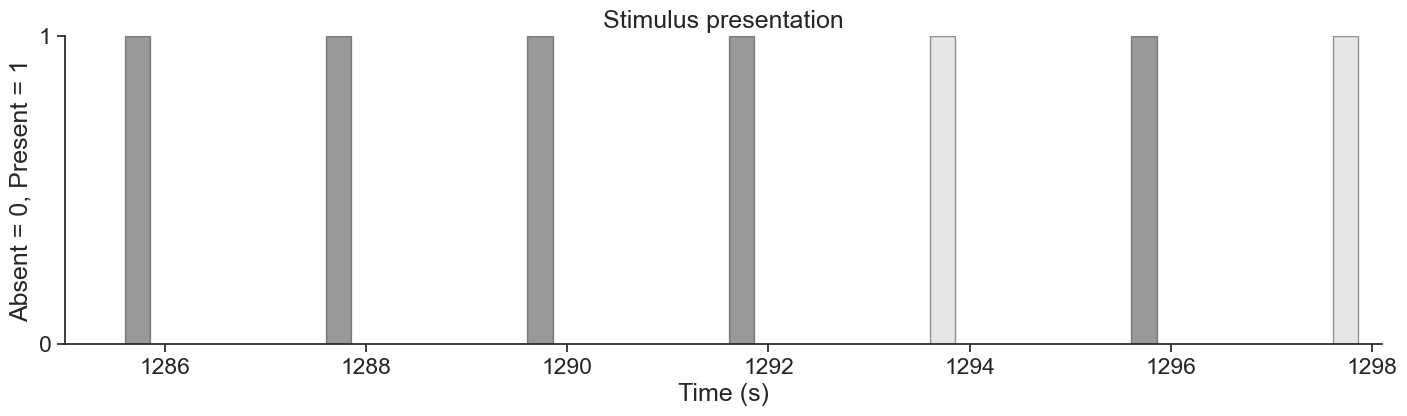

In [11]:
plot_stimulus()

### Preprocessing Spiking Data

There are multiple reasons for filtering units. Here, we will use four criteria: brain area, quality of units, firing rate and responsiveness
1. Brain area: we are interested in analyzing VISp units for this tutorial
2. Quality: we will only select "good" quality units
3. Firing rate: overall, we want units with a firing rate larger than 2 throughout all recordings
4. Responsiveness: Since the goal is to predict firing rate as a function of stimuli, we are now specifically interested in how neurons respond to white and/or black flashes. To focus on meaningful signal, we will (1) exclude units that show no spiking activity during stimulus presentation. To be concise, (2) we will select the most responsive units (top 30% responsiveness), and only use those for further analysis. We define responsiveness as the normalized difference between post stimulus and pre stimulus average firing rate.

:::{admonition} What does it mean for a unit to be of "good" quality?
:class: info
:class: dropdown

More information on unit quality metrics can be found in [Visualizing Unit Quality Metrics ](../visualization/visualize_unit_metrics.ipynb)

:::

In [12]:
# Filter units according 1, 2 and 3 criteria
units = units[
    (units["brain_area"]=="VISp") & 
    (units["quality"]=="good") & 
    (units["rate"]>2.0)
] 
print(units)

Index      rate      quality    brain_area
---------  --------  ---------  ------------
951765440  9.97935   good       VISp
951765454  5.47349   good       VISp
951765460  4.44892   good       VISp
951765467  9.98162   good       VISp
951765478  17.40465  good       VISp
951765485  13.97731  good       VISp
951765508  2.13461   good       VISp
...        ...       ...        ...
951768894  9.16155   good       VISp
951768901  3.99186   good       VISp
951768907  2.85765   good       VISp
951768925  2.28806   good       VISp
951769295  3.27275   good       VISp
951769299  4.57933   good       VISp
951769304  2.04729   good       VISp


Now, to calculate responsiveness, we need to do some preprocessing to align units spiking timestamps with the onset of the stimuli repetitions, and then take an average over the them. For this, we will use the [```compute_perievent```](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent) function, which allows to re-center time series and timestamps around particular events and compute spikes trigger average.

In [13]:
# Set window of perievent 500ms before and after the start of the event
window_size = (-.250, .500) 

# Calculate perievent for white stimuli
peri_white = nap.compute_perievent(timestamps = units,
                                        tref = flashes_white.starts,
                                        minmax = window_size
)

# Calculate perievent for black stimuli
peri_black = nap.compute_perievent(timestamps = units,
                                        tref = flashes_black.starts,
                                        minmax = window_size
)

The output of the perievent is a dictionary of [```TsGroup```](https://pynapple.org/generated/pynapple.TsGroup.html#pynapple.TsGroup) objects, indexed by each unit ID.

:::{admonition} Will the output of ```compute_perievent``` always be a dictionary?
:class: info
:class: dropdown

No. In this case it is because the input was a ```TsGroup``` containing the spiking information of multiple units. Had it been a ```Ts/Tsd/TsdFrame/TsdTensor``` (only one unit), then the output of ```compute_perievent``` would have been a ```TsGroup```.
For more information, please refer to [Pynapple documentation for processing perievents](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent)
:::

When we index one element of this dictionary, we can find the spike times centered around the stimulus for a single unit, which we could have changed with ```window_size```), for all presentations of stimuli. See the ref_times of the perievent are exactly the start times of stimuli presentation!

In [14]:
# Let's select one unit
example_id = 951765547 
print(f"length of the TsGroup: {len(peri_black[example_id])}")

# And print it's rates
print(f"perievent of unit {example_id}: \n {peri_black[example_id]}")

# Start times of black flashes presentation
print(f"black flashes start times: \n {flashes_black.starts}")

length of the TsGroup: 75
perievent of unit 951765547: 
 Index    rate      ref_times
-------  --------  -----------
0        34.66667  1285.6
1        nan       1287.6
2        1.33333   1289.6
3        nan       1291.61
4        2.66667   1295.61
5        6.66667   1303.62
6        2.66667   1307.62
...      ...       ...
68       nan       1561.83
69       nan       1563.83
70       4.0       1565.83
71       nan       1569.84
72       nan       1571.84
73       6.66667   1577.85
74       6.66667   1583.85
black flashes start times: 
 Time (s)
1285.600869922
1287.602559922
1289.604229922
1291.605889922
1295.609249922
1303.615919922
1307.619279922
...
1561.831629922
1563.833279922
1565.834999922
1569.838349922
1571.840009922
1577.845019922
1583.850039922
shape: 75


Let's inspect a bit further our perievents objects. If we grab the FIRST element of ```peri_black[example_id]```, we would get the spike times centered around the FIRST presentation of stimulus.

In [15]:
print(peri_black[example_id][0])

Time (s)
-0.249426091
-0.241726102
-0.219026132
-0.199726158
-0.18312618
-0.171592863
-0.157626215
...
0.057840163
0.077906803
0.104973433
0.188939987
0.235839924
0.272239875
0.311639823
shape: 26


It is expected to have negative spike times here because the spikes in ```peri_white``` and ```peri_black``` are centered around stimulus onset, so spikes which occured a bit before the onset would have "negative" values for time, as they occurred before $t=0$. Conversely, positive time values are indication of spikes that ocurred after stimulus onset.

We can also plot these aligned spikes, to visualize the rate and timing of the spikes as they relate to the stimulius. This type of plot is named [Peri Event Histogram (PETH)](https://en.wikipedia.org/wiki/Peristimulus_time_histogram). 

In [16]:
def plot_raster_peth(peri_color, units, color_flashes, bin_sz, smoothing=0.015):
    """
    Plot perievent time histograms (PETHs) and raster plots for multiple units.

    Parameters:
    -----------
    peri_color : dict
        Dictionary mapping unit names to binned spike count peri-stimulus data (e.g., binned time series).
    units : dict
        Dictionary of neural units, e.g., spike trains or trial-aligned spike events.
    color_flashes : str
        A label indicating the flash color condition ('black' or other), used for visual styling.
    bin_sz : float
        Size of the bin used for spike count computation (in seconds).
    smoothing : float
        Standard deviation for Gaussian smoothing of the PETH traces.
    """

    # Layout setup: 7 columns (units), 2 rows (split vertically into PETH and raster plot)
    n_cols = 7
    n_rows = 2
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_figheight(4)
    fig.set_figwidth(17)
    fig.tight_layout()

    # Use tab10 color palette for plotting different units
    colors = plt.cm.tab10.colors[:n_cols]

    # Extract unit names for iteration
    units_list = list(units.keys())[10:]

    start = 0
    end = int(n_rows / 2)  # Plot as many units as half the number of rows 
                            # each unit occupies 2 rows (one for peth and other for raster)

    for col in range(n_cols):
        for i, unit in enumerate(units_list[start:end]):
            u = peri_color[unit]
            line_color = colors[col]

            # Plot PETH (smoothed firing rate)
            ax[2*i, col].plot(
                (np.mean(u.count(0.01), 1) / bin_sz).smooth(std=smoothing),
                linewidth=2,
                color=line_color
            )
            ax[2*i, col].axvline(0.0)  # Stimulus onset line
            span_color = "black" if color_flashes == "black" else "silver"
            ax[2*i, col].axvspan(0, 0.250, color=span_color, alpha=0.3, ec="black")  # Stim duration
            ax[2*i, col].set_xlim(-0.25, 0.50)
            ax[2*i, col].set_title(f'{unit}')

            # Plot raster
            ax[2*i+1, col].plot(u.to_tsd(), "|", markersize=1, color=line_color, mew=2)
            ax[2*i+1, col].axvline(0.0)
            ax[2*i+1, col].axvspan(0, 0.250, color=span_color, alpha=0.3, ec="black")
            ax[2*i+1, col].set_ylim(0, 75)
            ax[2*i+1, col].set_xlim(-0.25, 0.50)

            # Shift window for next units
            start += 1
            end += 1

    # Y-axis and title annotations
    ax[0, 0].set_ylabel("Rate (Hz, all)")
    ax[1, 0].set_ylabel("Trial")
    if n_rows > 2:
        ax[2, 0].set_ylabel("Rate (Hz, all)")
        ax[3, 0].set_ylabel("Trial")
    fig.text(0.5, 0.00, 'Time from stim(s)', ha='center')
    fig.text(0.5, 1.00, f'PETH & Spike Raster Plot - {color_flashes} flashes', ha='center')

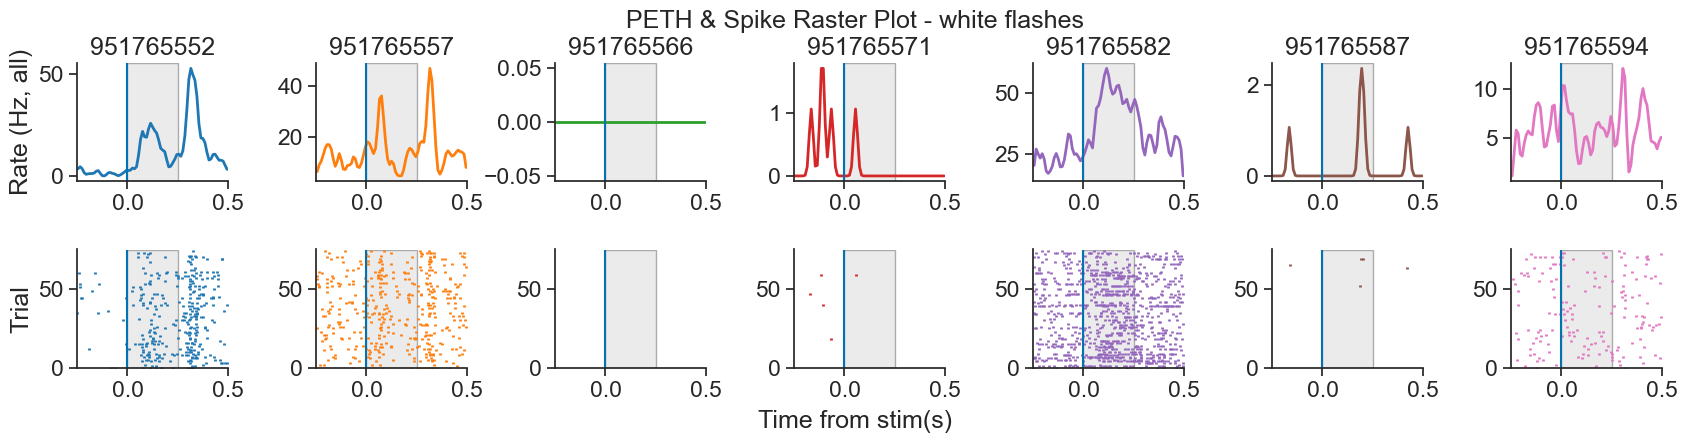

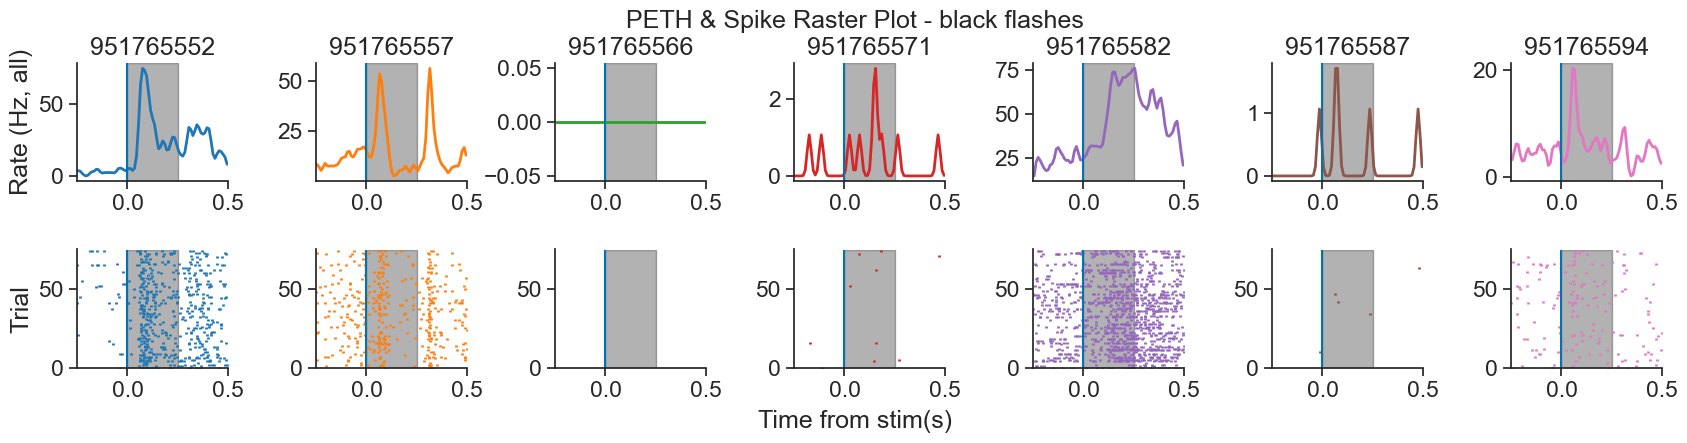

In [17]:
bin_sz = 0.005 # Bin size

plot_raster_peth(peri_white, units, "white", bin_sz)
plot_raster_peth(peri_black, units, "black", bin_sz)

:::{admonition} How to choose bin size?
:class: info
:class: dropdown

The bin size (```bin_sz```) refers to the size of the "binning" of the time series. A bin size of 0.005 means that one second will be split into 200 bins. Larger bins indicate lower temporal resolution, while smaller bins indicate higher temporal resolution. In this tutorial, we chose 0.005 as bin size , but it is worth noting that are different ways of calculating this value. How many bins you need depends on the temporal resolution of the process that you are modeling. This is a modelers choice, and there is no bin size fits all!
:::

:::{admonition} Why does the peth plot look so smooth?
:class: info
:class: dropdown

We use are using the [`smooth`](https://pynapple.org/generated/pynapple.Tsd.smooth.html#pynapple.Tsd.smooth) function from Pynapple to apply Gaussian smoothing to the perievent time series before plotting. This reduces trial-to-trial variability and emphasizes consistent temporal patterns in firing rate, making features like peaks or latency shifts easier to interpret—especially when spike trains are noisy or sparse.

In this tutorial, we use a Gaussian kernel with a standard deviation of 0.015 seconds.  
Given our bin size of `bin_sz = 0.005`, the sampling rate is: ```1 / bin_sz = 200 Hz```

This means we smooth over approximately 3 time bins.

For implementation details, refer to the [Pynapple documentation](https://pynapple.org/generated/pynapple.Tsd.smooth.html#pynapple.Tsd.smooth).

:::

In the plot above, we can see that some units (951765552, blue or 951765582, purple) are clearly more responsive than others (951765571, red - or even 951765566, green), which are apparently not modulated by the flashes. Thus, it would make sense to take a subset of the neurons, the most responsive ones, and model those.

We will now calculate responsiveness for each neuron as the normalized difference between average firing rate before and after stimulus presentation, and select the most responsive ones for further analyses.

In [18]:
def get_responsiveness(perievents, bin_sz):
    """Calculate responsiveness for each neuron. This is
    computer as:

    post_stim_av  : 
        Average firing rate during presentation (250ms) of stimulus across
        all instances of stimulus. 

    pre_stim_av :
        Average firing rate prior (250ms) to the presentation of stimulus
        accross all instances prior of stimulus. 

    responsiveness : 
        (post_stim_ave - pre_stim_av) / (post_stim_ave + pre_stim_av)

    Larger values indicate higher responsiveness to the stimuli.
        
    Parameters
    ----------
    perievents : TsGroup
        Contains perievent information of a subset of neurons
    bin_sz : float
        Bin size for calculating spike counts

    Returns
    ----------   
    resp_array : np.array
        Array of responsiveness information.
    resp_dict : dict
        Dictionary of responsiveness information. Indexed by each neuron's,
        contains responsiveness, pre_stim_av and post_stim_av information

    """
    resp_dict = {}
    resp_array = np.zeros(len(perievents.keys()), dtype=float)

    for index,unit in enumerate(perievents.keys()):
        # Count the number of timestamps in each bin_sz bin.
        peri_counts = perievents[unit].count(bin_sz)

        # Get the firing rate
        peri_rate = peri_counts/bin_sz

        # Compute average firing rate for each milisecond in the
        # the 250ms before stimulus presentation
        pre_stim = np.mean(peri_rate,1).restrict(nap.IntervalSet([-.25,0]))

        # Compute average firing rate for each milisecond in the
        # the 250ms after stimulus presentation
        post_stim = np.mean(peri_rate,1).restrict(nap.IntervalSet([0,.25]))

        pre_stim_av = np.mean(pre_stim)
        post_stim_av = np.mean(post_stim)
        responsiveness = (post_stim_av - pre_stim_av) / (post_stim_av + pre_stim_av)

        resp_dict[unit] = {
            "responsiveness": responsiveness,
            "pre_stim_av": pre_stim_av,
            "post_stim_av": post_stim_av,
        }
        resp_array[index] = responsiveness

    return resp_array, resp_dict

In [19]:
# Calculate responsiveness
responsiveness_white,_ = get_responsiveness(peri_white, bin_sz)
responsiveness_black,_ = get_responsiveness(peri_black, bin_sz)

# Add resposiveness as metadata for units
units.set_info(responsiveness_white=responsiveness_white)
units.set_info(responsiveness_black=responsiveness_black)

# See metadata
print(units)

Index      rate      quality    brain_area    responsiveness_white    responsiveness_black
---------  --------  ---------  ------------  ----------------------  ----------------------
951765440  9.97935   good       VISp          -0.14                   0.28
951765454  5.47349   good       VISp          -0.02                   0.02
951765460  4.44892   good       VISp          0.18                    0.0
951765467  9.98162   good       VISp          -0.17                   0.22
951765478  17.40465  good       VISp          0.2                     0.33
951765485  13.97731  good       VISp          0.15                    -0.39
951765508  2.13461   good       VISp          -0.46                   -0.23
...        ...       ...        ...           ...                     ...
951768894  9.16155   good       VISp          -0.09                   0.46
951768901  3.99186   good       VISp          -0.09                   -0.08
951768907  2.85765   good       VISp          0.49               

Now I can remove units without any firing throughout the whole stimulus presentation, with 0 responsiveness and also keep the top 30% most responsive units for ongoing analyses

In [20]:
# Nan values ocurr when there is division by zero aka firing rate before + firing rate after = 0 
units = units[~np.isnan(units["responsiveness_black"]) & ~np.isnan(units["responsiveness_white"])]

# Remove units with 0 responsiveness
units = units[(np.abs(units["responsiveness_black"])>0.01 ) & (np.abs(units["responsiveness_white"]) >0.01)]

# Get threshold for top 30% most resopnsive
thresh_black = np.percentile(units["responsiveness_black"], 70)
thresh_white = np.percentile(units["responsiveness_white"], 70)

# Only keep units that are within the 30% most responsive for either black or white
units = units[(units["responsiveness_black"] > thresh_black) | (units["responsiveness_white"] > thresh_white)]

print(units)

Index      rate      quality    brain_area    responsiveness_white    responsiveness_black
---------  --------  ---------  ------------  ----------------------  ----------------------
951765530  2.95127   good       VISp          0.69                    0.79
951765552  2.32971   good       VISp          0.75                    0.81
951765571  2.77426   good       VISp          -0.6                    0.5
951765582  14.77795  good       VISp          0.3                     0.36
951765587  2.62793   good       VISp          0.5                     0.5
951765647  9.12497   good       VISp          1.0                     0.07
951765666  9.72245   good       VISp          0.49                    0.44
...        ...       ...        ...           ...                     ...
951768830  10.90978  good       VISp          0.15                    0.47
951768881  2.06258   good       VISp          0.5                     0.27
951768888  2.90921   good       VISp          -0.2                   

### Revision of stimuli and spiking

Now that we have selected the units for our analyses, we can see how some of these neurons look in response to the stimuli in a PETH

In [21]:
def plot_peri_side_by_side(params,
                           bin_sz,
                           simulation = False,
                           smoothing = 0.015,
                           ):
    """ Top neurons should be range from 0 to last shape dim in case of simulation
    """
    peri_white, peri_black = params

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

    # Plot White
    ax = axs[0]
    
    for unit in list(peri_white.keys()):
        if simulation and not hist: 
            peri_u = np.mean(peri_white,axis=1)[:,unit]
            ax.plot(peri_u, linewidth=1)
        else:
            peri_u = peri_white[unit]
            peri_u_count = peri_u.count(bin_sz)

            peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
            peri_u_rate_conv = peri_u_coun_conv_mean / bin_sz
            ax.plot(peri_u_rate_conv, linewidth=1)
    

    ax.set_xlim(-0.25, 0.50) # restrict
    ax.axvspan(0, 0.250, color="silver", alpha=0.3, ec="black")
    ax.axvline(0.0, color="black")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_title("Perievent white flashes")

    # Plot Black
    ax = axs[1]
    for unit in list(peri_black.keys()):
        if simulation: 
            peri_u = np.mean(peri_black,axis=1)[:,unit]
            ax.plot(peri_u, linewidth=1)
        else:
            peri_u = peri_black[unit]
            peri_u_count = peri_u.count(bin_sz)

            peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
            peri_u_rate_conv = peri_u_coun_conv_mean / bin_sz
            ax.plot(peri_u_rate_conv, linewidth=1)

    ax.set_xlim(-0.25, 0.50) # restrict
    ax.axvspan(0, 0.250, color="black", alpha=0.3, ec="black")
    ax.axvline(0.0, color="black")
    ax.set_title("Perievent black flashes")
    fig.text(0.5, -.01, 'Time from stim(s)', ha='center')

    plt.tight_layout()
    plt.show()


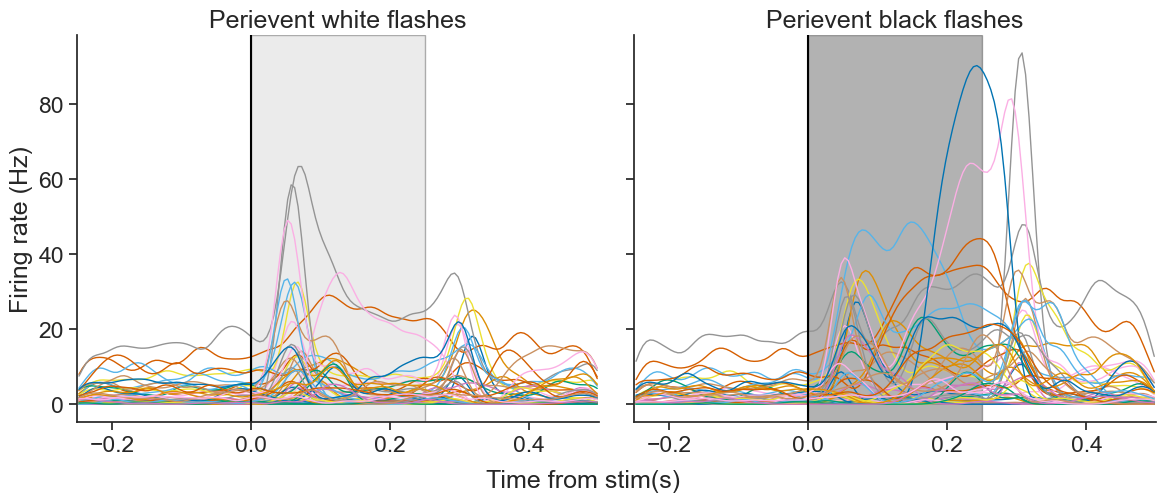

In [22]:
# Calculate perievent for white stimuli - subset of units
peri_white = nap.compute_perievent(timestamps = units,
                                        tref = flashes_white.starts,
                                        minmax = window_size
)

# Calculate perievent for black stimuli - subset of units
peri_black = nap.compute_perievent(timestamps = units,
                                        tref = flashes_black.starts,
                                        minmax = window_size
)

params_obs = [peri_white, 
              peri_black]

plot_peri_side_by_side(
    params_obs,
    bin_sz
)

or in a raster plot!

In [23]:
def raster_plot(units, n_neurons = len(units), n_flashes = 5, n_seconds = 13, offset = .5):
    n_neurons = len(units)
    n_flashes = 5
    n_seconds = 13
    offset = .5

    start = data["flashes_presentations"]["start"].min() - offset # Start a little bit earlier than the first flash presentation
    end = start + n_seconds

    # Restrict the neurons to the period of presentation of plotted stimuli
    units = units.restrict(nap.IntervalSet(start, end))

    # Change type to tsd to access spiking times. 
    # Change the metadata information so each different 
    # neuron is now tagged with an ID from 1 to 10
    # for ease of plot
    neurons_to_plot = units.to_tsd([i+1 for i in range(n_neurons)])

    fig, ax = plt.subplots(figsize = (17, 4))

    ax.plot(neurons_to_plot, "|", markersize=2, mew=2)

    # Different coloured flashes
    [ax.axvspan(
        s, 
        e, 
        color = "silver", 
        alpha=.4, 
        ec="black"
        ) for s, e in zip(
            flashes_white[:n_flashes].start, 
            flashes_white[:n_flashes].end
        )
    ]

    [ax.axvspan(
        s, 
        e, 
        color = "black", 
        alpha=.4, 
        ec="black"
        ) for s, e in zip(
            flashes_black[:n_flashes].start, 
            flashes_black[:n_flashes].end
        )
    ]

    plt.xlabel("Time (s)")
    plt.ylabel("Unit")
    ax.set_title("Primary Visual Cortex (VISp) units spikes and stimuli")
    plt.xlim(start,end) 
    
    plt.show()

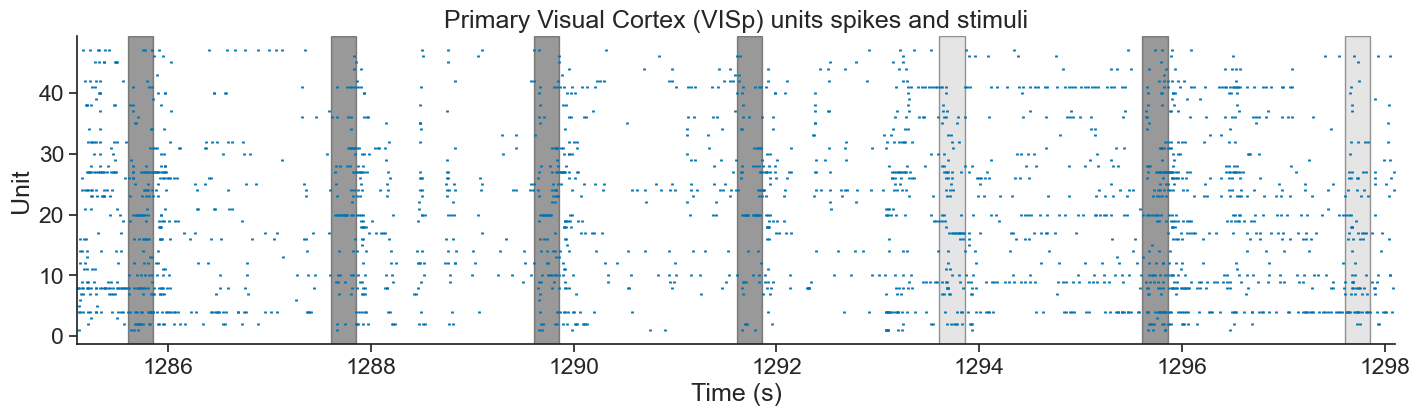

In [24]:
raster_plot(units)

Importantly, we are interested solely in the response of the unit around the stimuli. Let's restrict our time series around the stimuli presentation.

In [25]:
dt = .50
start = flashes.start - dt
end = flashes.end + dt

ep_flashes = nap.IntervalSet(start,end, metadata=flashes.metadata) 
ep_flashes_white = ep_flashes[ep_flashes["color"]=="1.0"]
ep_flashes_black = ep_flashes[ep_flashes["color"]=="-1.0"]

### Splitting the dataset in train and test
We could train the model with the whole dataset, but then we would not have a way to assess whether our model is capable of making accurate predictions or simply overfitting to our data. The simplest way around this is to have a reserved part of the data for testing. However, the precise details on how to do this splitting depends on the question, the data, and the researcher.

Here, we will split the data in two: 70% will be for training and 30% will be for testing. However, we can't simply grab the first 70% of the timeseries - what if we are biasing our sample and there are some neurons that respond only towards the end or the beginning of the experiment? For that, we will gather one every three flashes, and those will go to the testing set. The rest, will go to the training set.

In [26]:
# We take one every three flashes (33% of all flashes of test)
flashes_test_white = ep_flashes_white[::3]
flashes_test_black = ep_flashes_black[::3]

Pynapple has a nice function to get all the epochs: [```set_diff```](https://pynapple.org/generated/pynapple.IntervalSet.set_diff.html). With it, we can get all of the interval sets which are not in the interval set passed as argument.

In [27]:
# The remaining is separated for training
flashes_train_white = ep_flashes_white.set_diff(flashes_test_white)
flashes_train_black = ep_flashes_black.set_diff(flashes_test_black)

Consider black and white for test and train
using [```union```](https://pynapple.org/generated/pynapple.IntervalSet.union.html#pynapple.IntervalSet.union)

In [28]:
# Merge both stimuli types in a single interval set
flashes_test = flashes_test_white.union(flashes_test_black)
flashes_train = flashes_train_white.union(flashes_train_black)

Now that we have our intervals correctly, we can use [```restrict```](https://pynapple.org/generated/pynapple.TsGroup.restrict.html#pynapple.TsGroup.restrict) to get our test and train sets for units

In [29]:
# General spike counts
units_counts = units.count(bin_sz, ep = ep_flashes)

# Restrict counts to test and train
units_counts_test = units_counts.restrict(flashes_test)
units_counts_train = units_counts.restrict(flashes_train)

## Fitting a GLM

### Preparing the data for NeMos
Now that we have a good understanding of our data, and that we have splitted our dataset in the corresponding test and train subsets, we are almost ready to run our model. However, before we can construct it, we need to get our data in the right format.

When fitting a single neuron, NeMoS requires that the predictors and spike counts it operates on have the following properties:

- predictors and spike counts must have the same number of time points.
- predictors must be two-dimensional, with shape ```(n_time_bins, n_features)```. So far, we have two features in this tutorial: white and black flashes.
- spike counts must be one-dimensional, with shape ```(n_time_bins,)```. 
- predictors and spike counts must be jax.numpy arrays, numpy arrays or pynapple TsdFrame/Tsd.

When fitting multiple neurons, spike counts must be two-dimensional: ```(n_time_bins, n_neurons)```. Moreover, in that case, spike counts can be Pynapple TsGroup objects as well.

First, we require that our predictors and our spike counts have the same number of time bins.

In [30]:
# Create a ts frame filled by zeros, for the size of units_counts
predictors = nap.TsdFrame(t=units_counts.t, d=np.zeros((len(units_counts), 2)), columns = ['white', 'black'])

At the moment, the flashes are in a IntervalSet, we need to grab them and make them time series of stimuli, separated by black and white (because we are interested in how neurons' responses are modulated by each individual stimulus type separately).

In [31]:
# Check whether there is a flash within a given bin of spikes
# If there is not, put a nan in that index
idx_white = flashes_white.in_interval(units_counts)
idx_black = flashes_black.in_interval(units_counts)

# Replace everything that is not nan with 1 in the corresponding column
predictors.d[~np.isnan(idx_white), 0] = 1
predictors.d[~np.isnan(idx_black), 1] = 1

In [32]:
print(f"predictors shape: {predictors.shape}")
print(f"\ncount shape: {units_counts.shape}")

predictors shape: (37500, 2)

count shape: (37500, 47)


They match in the first dimension because they have the same number of timepoints! Meanwhile, in the second dimension, counts has 47 because the selected units for this tutorial sums to 47, while predictors is 2 because we have black and white flashes.

Just to make sure that we got the right output, let's plot our new "predictors" time series as lines alongside our first plot

In [33]:
def stimuli_plot(predictors, n_flashes = 5, n_seconds = 13, offset = .5):
    n_flashes = 5
    n_seconds = 13
    offset = .5

    start = data["flashes_presentations"]["start"].min() - offset # Start a little bit earlier than the first flash presentation
    end = start + n_seconds


    fig, ax = plt.subplots(figsize = (17, 4))

    #ax.plot(neurons_to_plot, "|", markersize=2, mew=2)

    # Different coloured flashes
    [ax.axvspan(s, e, color = "silver", alpha=.4, ec="black") for s, e in zip(flashes_white[:n_flashes].start, flashes_white[:n_flashes].end)]
    [ax.axvspan(s, e, color = "black", alpha=.4, ec="black") for s, e in zip(flashes_black[:n_flashes].start, flashes_black[:n_flashes].end)]
    plt.plot(predictors["white"], "o-", color= "silver")
    plt.plot(predictors["black"], "o-", color= "black")


    plt.xlabel("Time (s)")
    plt.ylabel("Absent = 0, Present = 1")
    ax.set_title("Presented Stimuli")
    
    plt.xlim(start,end) # Note to Guillaume: cant remove xlim because if i do the plot looks weird at the beginning as if there was no spiking

    # Only use integer values for ticks
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()


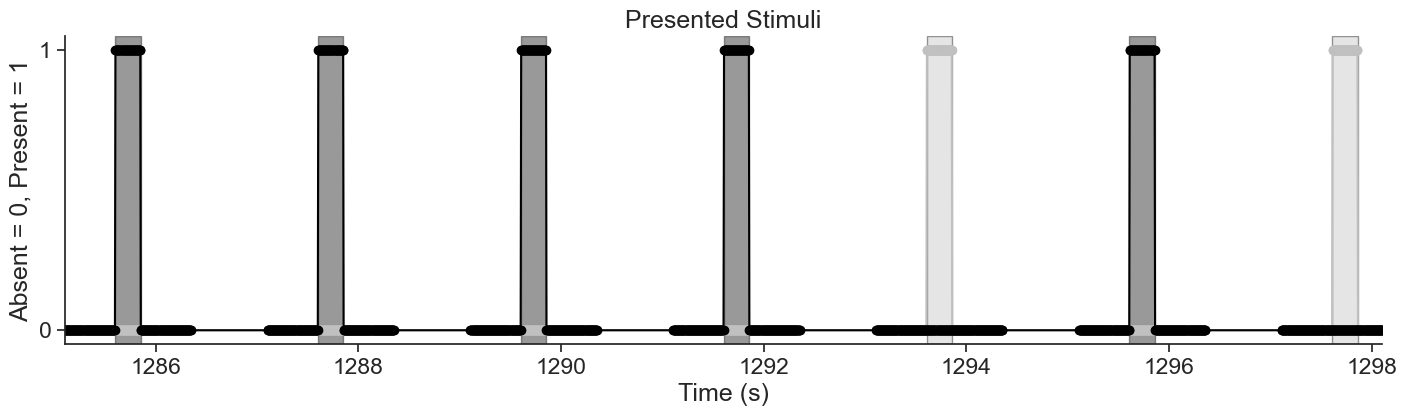

In [34]:
stimuli_plot(predictors)

They match perfectly! 

Secondly, we need to ensure our variables are the proper shape:

- ```predictors : (n_time_bins, n_features)```
- ```counts : (n_time_bins, n_neurons)```

In principle, our current variables are in a proper shape - but in a moment we will see why this set up of predictors is not ideal!

As a last preprocessing step, let's just split these predictors in train and test.

In [35]:
predictors_test = predictors.restrict(flashes_test)
predictors_train = predictors.restrict(flashes_train)

### Constructing the design matrix using basis functions

Right now, our predictors are composed by black and white flashes at every time point, but that would imply assuming that the neuron's spiking behavior is only driven by the instantaneous flash presentation. However, we know neurons integrate information over time, so why not changing our predictors to reflect that? 

We can achieve this by including variables that represent the history of exposure to the flashes. For this, we must decide the duration of time that we think is relevant: does the exposure to flashes 10ms ago matter? What about 100ms ago? 1s? We should use priori knowledge of our system to determine a initial value. 

For this tutorial, we will use the whole duration of the stimuli as relevant history. That is, we will model each unit’s response to 250 ms full-field flashes by capturing how stimulus history over that duration influences spiking. We therefore define a 250 ms stimulus window, aligned with the flash onset, which spans the entire stimulus duration. This window enables the GLM to learn how the neuron's firing rate evolves throughout the flash. Using a shorter window could omit delayed effects, while a longer window may incorporate unrelated post-stimulus activity.

To construct our stimulus history predictor, we could generate time-lagged copies of the stimulus input (in the form of a [Hankel Matrix](https://en.wikipedia.org/wiki/Hankel_matrix)). Specifically, the value of the first predictor at time $ t $ would correspond to the stimulus at time $ t $, while the second predictor would capture the stimulus at time $ t - 1 $ , and so on, up to a maximum lag corresponding to the length of the stimulus integration window (250 ms in our case).

:::{admonition} How do you build a Hankel matrix?
:class: info
:class: dropdown

Every row is a shifted copy of the row above!

![henkel_matrix](../../data/images/henkel_matrix.gif)

Construction of Hankel Matrix. Modified from <a href="https://pillowlab.princeton.edu/pubs/pillow_TutorialSlides_Cosyne2018.pdf">Pillow 2018 Cosyne tutorial </a>

:::

However, modeling each time lag with an independent parameter leads to a high-dimensional filter that is prone to overfitting! (Given that we are using a bin size of 0.005, we would end up with 50 lags = 50 parameters per flash color!) A better idea is to do some dimensionality reduction on these predictors, by parametrizing them using basis functions. These will allow us to capture interesting non-linear effects with a relatively low-dimensional parametrization that preserves convexity. 

NeMoS has a whole library of basis objects available at [```nmo.basis```](https://nemos.readthedocs.io/en/latest/background/basis/README.html#table-basis), and choosing which set of basis functions and their parameters, like choosing the duration of the flash history predictor, requires knowledge of your problem, but can later be examined using model comparison tools.

For history-type inputs like we’re discussing, the raised cosine log-stretched basis first described in [Pillow et al., 2005](https://www.jneurosci.org/content/25/47/11003) is a good fit. This basis set has the nice property that their precision drops linearly with distance from event, which is a makes sense for many history-related inputs in neuroscience: whether an input happened 1 or 5 ms ago matters a lot, whereas whether an input happened 51 or 55 ms ago is less important.

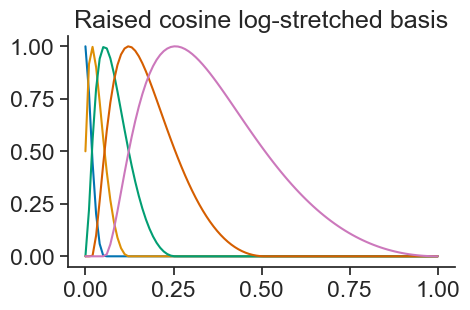

In [36]:
# Duration of stimuli
stimulus_history_duration = 0.25 

# Window length in bin size units
window_len = int(stimulus_history_duration / bin_sz)

basis_example = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs = 5, 
    window_size = window_len, 
)
sample_points, basis_values = basis_example.evaluate_on_grid(100)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(sample_points, basis_values)
ax.set_title("Raised cosine log-stretched basis")
plt.show()

When we instantiate this object, the only arguments we need to specify is the number of functions we want and the mode of operation of the basis:
- Number of functions: with more basis functions, we’ll be able to represent the effect of the corresponding input with the higher precision, at the cost of adding additional parameters.
- Mode of operation: either ```Conv``` for convolutional or ```Eval```for evaluation form of the basis. This is determined by the type of feature we aim to represent.

:::{admonition} When should I use the convolutional or evaluation form of the basis?
:class: info
- Evaluation bases transform the input through the non-linear function defined by the basis. This can be used to represent features such as spatial location and head direction.
- Convolution bases apply a convolution of the input data to the bank of filters defined by the basis, and is particularly useful when analyzing data with inherent temporal dependencies, such as spike history or the history of flash exposure in this example. In convolution mode, we must additionally specify the ```window_size```, the length of the filters in bins.

:::

In [37]:
# Duration of stimuli
stimulus_history_duration = 0.25 

# Window length in bin size units
window_len = int(stimulus_history_duration / bin_sz)

# Initialize basis objects
# White basis
basis_white = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs = 5, 
    window_size = window_len, 
    label = "white"
)
# Black basis
basis_black = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs = 5, 
    window_size = window_len, 
    label = "black"
)

Using the ```compute_features```function, NeMos convolves our input features (predictors) with the basis object to compress them. How does that look like?

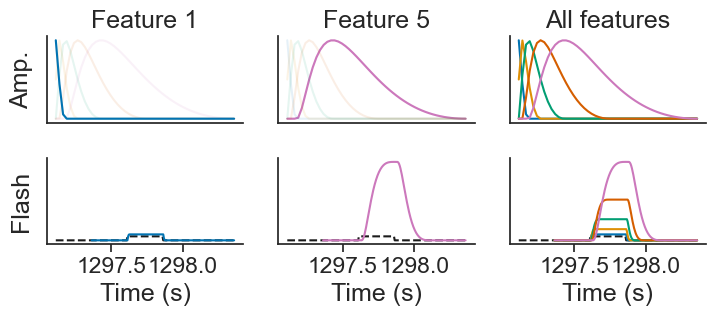

In [38]:
# Use only first flash presentation for plot
interval= flashes_train_white[0]

# Compute features
features = basis_white.compute_features(predictors_train["white"])

# Initialize plot
fig, axes = plt.subplots(2, 3, sharey="row", figsize=(7.5, 3.5), tight_layout=True)

# Create time axis
time, basis = basis_white.evaluate_on_grid(basis_white.window_size)
time *= window_len

# Restrict predictors and features to first flash presentation
flashes = predictors_train["white"].restrict(interval)
features = features.restrict(interval) 

# Plot raw predictors
for ax in axes[1, :]:
    ax.plot(flashes, "k--", label="true")
    ax.set_xlabel("Time (s)")

# Plot first basis function
axes[0, 0].plot(time, basis, alpha=0.1)
axes[0, 0].set_xticks([])
axes[0, 0].plot(time, basis[:, 0], "C0", alpha=1)
axes[0, 0].set_ylabel("Amp.")
axes[0, 0].set_yticks([])

# Plot first Feature (first basis function convolved with input)
axes[0, 0].set_title("Feature 1")
axes[1, 0].plot(features[:, 0], label="conv.")
axes[1, 0].set_ylabel("Flash")
axes[1, 0].set_yticks([])

# Plot last basis function
axes[0, 1].plot(time, basis[:, -1], f"C{basis.shape[1]-1}", alpha=1)
axes[0, 1].set_xticks([])
axes[0, 1].set_title(f"Feature {basis.shape[1]}")

# Plot last feature
axes[1, 1].plot(features[:, -1], f"C{basis.shape[1]-1}")
axes[0, 1].plot(time, basis, alpha=0.1)

# Plot all basis functions
axes[0, 2].plot(time, basis)
axes[0, 2].set_xticks([])
axes[0, 2].set_title("All features")

# Plot all features
axes[1, 2].plot(features)

plt.show()

On the top row, we can see the basis function, same as in the plot above. On the bottom row, we are showing one flash presentation, as a dashed line, and corresponding features over a small window of time. These features are the result of a convolution between the basis function on the top row with the black dashed line showed below. The basis functions get progressively wider and delayed from the flash onset, so we can think of the features as weighted averages that get progressively later and smoother.

In the leftmost plot, we can see that the first feature almost perfectly tracks the input. Looking at the basis function above, that makes sense: this function’s max is at 0 and quickly decays. In the middle plot, we can see that the last feature has a fairly long lag compared to the flash, and is a lot smoother. Looking at the rightmost plot, we can see that the other features vary between these two extremes, getting smoother and more delayed.

These are the elements of our feature matrix: representations of not just the instantaneous presentation of a flash, but also the its history. Let’s see what this looks like when we go to fit the model!

In our case, we want our basis to be composed by both black and white flashes features. For that, we can build an additive basis, simply by adding our already declared basis objects. 

In [39]:
# Define additive basis object
additive_basis = basis_white + basis_black

# Convolve basis with inputs - train set
X_train = additive_basis.compute_features(
    predictors_train["white"], # Corresponding to basis_white
    predictors_train["black"]  # Corresponding to basis_black
)

# Convolve basis with inputs - test set
X_test = additive_basis.compute_features(
    predictors_test["white"], 
    predictors_test["black"]
)

:::{admonition} More resources on basis functions
:class: info
:class: dropdown
- [Nemos fit head-direction population tutorial](https://nemos.readthedocs.io/en/latest/tutorials/plot_02_head_direction.html): For a step by step explanation of how to build the design matrix first as a result of convolving the features with the identity matrix, and then by using basis functions, alongside nice visualizations.
- [Flatiron Institute Introduction to GLMs tutorial](https://flatironinstitute.github.io/neurorse-workshops/workshops/jan-2025/branch/main/full/day2/current_injection.html#fitting-the-model): For a detailed explanation, step by step, on how predictors look with and without basis functions, with nice visualizations as well.
- [Bishop, 2009](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf): Section 3.1 for a formal description of what basis functions are and some examples of them.
:::

### Initialize and fit a GLM: single unit

Now we are finally ready to start our model!

First, we need to define our GLM model object. To initialize our model, we need to specify the ```solver_name```, the ```regularizer```, the ```regularizer_strength``` and the ```observation_model```. All of these are optional.

- ```solver_name```: this string specifies the solver algorithm. The default behavior depends on the regularizer, as each regularization scheme is only compatible with a subset of possible solvers.
- ```regularizer```: this string or object specifies the regularization scheme. Regularization modifies the objective function to reflect your prior beliefs about the parameters, such as sparsity. Regularization becomes more important as the number of input features, and thus model parameters, grows. NeMoS’s solvers can be found within the nemos.regularizer module. If you pass a string matching the name of one of our solvers, we initialize the solver with the default arguments. If you need more control, you will need to initialize and pass the object yourself.
- ```observation_model```: this object links the firing rate and the observed data (in this case spikes), describing the distribution of neural activity (and thus changing the log-likelihood). For spiking data, we use the Poisson observation model.

For this tutorial, we’ll use a LBFGS solver with Ridge regularization, and a regularization strength of 0.005.

:::{admonition} Why LBFGS?
:class: info
:class: dropdown

LBFGS is a quasi-Netwon method, that is, it uses the first derivative (the gradient) and approximates the second derivative (the Hessian) in order to solve the problem. This means that LBFGS tends to find a solution faster and is often less sensitive to step-size. Try other solvers to see how they behave!
:::

:::{admonition} What is regularization?
:class: info
:class: dropdown

When fitting models, it is generally recommended to use regularization, a technique that adds a constraint or penalty to the model’s cost function. Regularization works by discouraging the coefficients from reaching large values.

Penalizing large coefficients is beneficial because it helps prevent overfitting, a phenomenon in which the model fits the training data too closely, capturing noise instead of the underlying pattern. Large coefficients often indicate a model that is too complex or sensitive to small fluctuations in the data. By keeping coefficients smaller and more stable, regularization promotes simpler models that generalize better to unseen data, improving predictive performance and robustness.

In this tutorial, we will use Ridge regularization (or L2 regularization). In this type of regularization, the penalty term added to the loss function is:

$$
\text{Penalty} = \frac{\lambda}{2N} \sum_{j} \theta_j^2
$$

where $\lambda$ is the regularization strength, $N$ is the number of samples and $\theta_j$ are the model coefficients, stored in model.coef_

Please refer to [NeMos documentation](https://nemos.readthedocs.io/en/latest/generated/regularizer/nemos.regularizer.Ridge.html#nemos.regularizer.Ridge) for more details on how this was implemented.

:::

In [40]:
regularizer_strength = 0.0004
# Initialize model object of a single unit
model = nmo.glm.GLM(
    regularizer = "Ridge",
    regularizer_strength = regularizer_strength,
    solver_name="LBFGS", 
)

:::{admonition} Where did the regularization strength value come from?
:class: info
:class: dropdown

We conducted cross validation to obtain the regularization strength:

```
# Initialize model object
model = nmo.glm.GLM(
    regularizer = "Ridge",
    regularizer_strength = 0.01,
    solver_name="LBFGS", 
    #solver_kwargs=dict(tol=10**-12)
)

# Create parameter grid
param_grid = {
    "regularizer_strength" : 
    np.geomspace(10**-9, 10, 10)
}

# Instantiate the grid search object
grid_search = GridSearchCV(
    model,param_grid, 
    cv=5
    )

# Run grid search
grid_search.fit(X_train, u_counts_train)

# Print optimal parameter
print(grid_search.best_estimator_.regularizer_strength)
>>> 0.00035938136638046257
```
::: 

In [41]:
# Choose an example unit
unit_id = 951765530

# Get counts for train and test for said unit
u_counts_train = units_counts_train.loc[unit_id]
u_counts_test = units_counts_test.loc[unit_id]

We intend the NeMos models to be used like [scikit-learn](https://scikit-learn.org/stable/getting_started.html) estimators. In these, a model instance is initialized with hyperparameters (like regularization strength, solver, etc), and then we can call the ```fit()``` function to fit the model to data. Since we have already created our model and have our data, we can go ahead and call ```fit()```.

In [42]:
model.fit(X_train, u_counts_train)

GLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.0004,
    solver_name='LBFGS'
)

Now that we’ve fit our data, we can retrieve the resulting parameters. Similar to scikit-learn, these are stored as the ```coef_```and ```intercept_``` attributes:

In [43]:
print(f"firing_rate(t) = exp({model.coef_} * flash(t) + {model.intercept_})")

firing_rate(t) = exp([ 4.7231350e-02  8.6658791e-02 -5.3069461e-04 -3.9296657e-01
  2.5499049e-01 -5.6000259e-03 -5.5471651e-02  4.0737819e-02
  5.4253060e-01 -2.1212803e-01] * flash(t) + [-5.5891113])


Note that ```model.coef_``` has shape ```(n_features, )```, while ```model.intercept_``` has shape (```n_neurons```):

In [44]:
print(model.coef_.shape)
print(model.intercept_.shape)

(10,)
(1,)


### Assess GLM performance: predict

Although it is nice to see the parameters, just by looking at them we cannot tell how good our model is doing - How do we assess this?

For this, we can use the model to predict firing rates and compare that to the smoothed spike train. By calling [```predict```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.predict.html#nemos.glm.GLM.predict), we can get the model's predicted firing rate for this data (the output of the nonlinearity)

In [45]:
# Use predict to obtain the firing rates
pred_unit = model.predict(X_test)

# convert units from spikes/bin to spikes/sec
pred_unit = pred_unit/ bin_sz

Now, we can use pynapple function ```perievent_continuous``` to re-center the timestamps of the predicted rates around the stimulus presentations, in a similar manner than at the beginning of the tutorial. In contrast to ```perievent```, ```perievent_continuous``` allows us to center a continuous time series, which is precisely what we have here.

In [46]:
print(f"pred_unit type: {type(pred_unit)}")

pred_unit type: <class 'pynapple.core.time_series.Tsd'>


In [47]:
# Using that predicted rate, we can compute a perievent
window_size = (-.250,.500)
peri_white_pred_unit = nap.compute_perievent_continuous(timeseries = pred_unit, 
                                        tref = nap.Ts(flashes_test_white.start+.50), # +50 because we added +.50 at beginning and end of stimulus
                                        minmax=window_size
)  
peri_black_pred_unit = nap.compute_perievent_continuous(timeseries = pred_unit, 
                                        tref = nap.Ts(flashes_test_black.start+.50), # +50 because we added +.50 at beginning and end of stimulus
                                        minmax=window_size
)  

peri_white_pred_unit

Time (s)    0        1        2        3        4        ...
----------  -------  -------  -------  -------  -------  -----
-0.25       nan      nan      0.74767  nan      nan      ...
-0.245      0.74767  0.74767  0.74767  0.74767  0.74767  ...
-0.24       0.74767  0.74767  0.74767  0.74767  0.74767  ...
-0.235      0.74767  0.74767  0.74767  0.74767  0.74767  ...
-0.23       0.74767  0.74767  0.74767  0.74767  0.74767  ...
-0.225      0.74767  0.74767  0.74767  0.74767  0.74767  ...
-0.22       0.74767  0.74767  0.74767  0.74767  0.74767  ...
...         ...      ...      ...      ...      ...      ...
0.47        0.75874  0.75874  0.75424  0.75874  0.75874  ...
0.475       0.75424  0.75424  0.75119  0.75424  0.75424  ...
0.48        0.75119  0.75119  0.74929  0.75119  0.75119  ...
0.485       0.74929  0.74929  0.74824  0.74929  0.74929  ...
0.49        0.74824  0.74824  0.74778  0.74824  0.74824  ...
0.495       0.74778  0.74778  0.74767  0.74778  0.74778  ...
0.5         0.74767  0

The resulting object is a Pynapple ```TsdFrame``` of shape time x trials (we are defining one trial as one presentation of stimuli).

Now, we can plot the PETH of both the average rate of unit and the average predicted rate.

In [48]:
def plot_peri_predict(
        peri_white_pred_unit, 
        peri_black_pred_unit, 
        peri_white, 
        peri_black,
        unit_id = unit_id
    
):
    fig, ax = plt.subplots(1,2,figsize=(17, 4), sharey=True)
    color = (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
    ### white
    # predicted
    ax[0].plot(np.mean(peri_white_pred_unit,axis=1), linewidth=2, color="red", label = "predicted")

    peri_u = peri_white[unit_id]
    peri_u_count = peri_u.count(bin_sz)

    peri_u_count_conv_mean = np.mean(peri_u_count, 1).smooth(std=0.015)
    peri_u_rate_conv = peri_u_count_conv_mean / bin_sz
    # observed
    ax[0].plot(peri_u_rate_conv, linewidth=2, color=color)
    ax[0].axvline(0.0)
    ax[0].axvspan(0, 0.250, color="silver", alpha=0.3, ec="black")
    ax[0].set_xlim(-.25, .5)

    ax[0].set_title("White flashes")

    #### black
    # predicted
    ax[1].plot(np.mean(peri_black_pred_unit,axis=1), linewidth=2, color="red")

    peri_u = peri_black[unit_id]
    peri_u_count = peri_u.count(bin_sz)

    peri_u_count_conv_mean = np.mean(peri_u_count, 1).smooth(std=0.015)
    peri_u_rate_conv = peri_u_count_conv_mean / bin_sz
    # observed
    ax[1].plot(peri_u_rate_conv, linewidth=2, color=color, label = "observed")
    ax[1].axvline(0.0)
    ax[1].axvspan(0, 0.250, color="black", alpha=0.3, ec="black")
    ax[1].set_xlim(-.25, .5)

    ax[1].set_title("Black flashes")
    ax[0].set_ylabel("Rate (Hz)")

    fig.text(0.5, -.05, 'Time from stim(s)', ha='center')
    fig.text(0.5, .95, f'PETH unit {unit_id}', ha='center')
    fig.legend()
    plt.show()


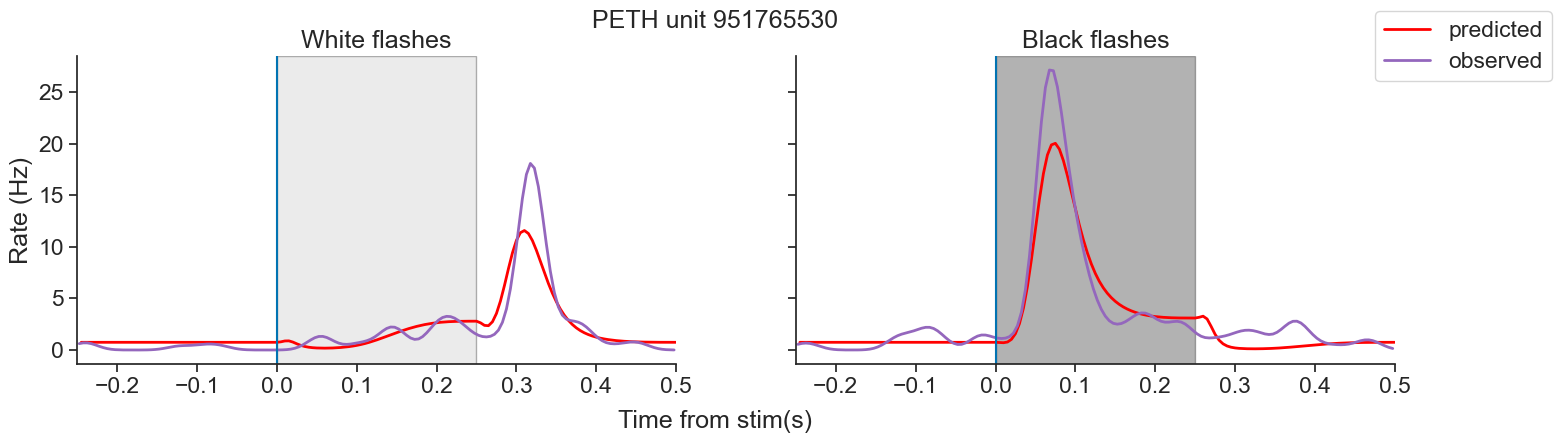

In [49]:
plot_peri_predict(peri_white_pred_unit, 
        peri_black_pred_unit, 
        peri_white, 
        peri_black
)

What do we see here?
- Predicted firing rate increases upon exposure to flashes in a similar manner as the unit — Success!
- ?
- ?

In this tutorial, for conciseness, we will use the regularizer strength obtained for this single neuron for the whole population. However, please note that when running your own analysis, it is necessary to find the optimal regularizer strength per neuron, as nothing guarantees that the optimal solution for this neuron will be the optimal solution for the next.

### Initialize and fit a GLM: population of units
NeMoS has a separate [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html) object for fitting a population of neurons. This is equivalent to fitting each individually in a loop, but faster. It operates very similarly to the GLM object we use here: it still expects a 2d input, with neurons concatenated along the second dimension. 

The first step is initializing the model, as with the ```GLM``` object.

In [50]:
model_stimuli = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = regularizer_strength,
    solver_name="LBFGS" 
)

Our input for the ```PopulationGLM``` can be the same basis object we used for fitting a single unit. Since we now want to fit all neurons, the counts for our model will be ```units_counts_train```. With that, we call ```model.fit()``` to fit our model.

In [51]:
model_stimuli.fit(
    X_train,
    units_counts_train
)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.0004,
    solver_name='LBFGS'
)

### Assess GLM Population performance: heatmap

To evaluate how well our Population GLM model captures the neural responses, we can visualize the activity of all units using a heatmap. Here's how we construct it:

1. Predict: we get the predicted firing rate of each timepoint for each neuron using ```predict``` with our ```PopulationGLM``` object.
2. Re center timestamps: we can use pynapple function ```perievent_continuous``` to re-center spiking activity timestamps around the presentation of stimuli.
2. Z-scoring: We normalize the activity of each unit by converting it to z-scores. This removes differences in firing rate scale and allows us to focus on the relative response patterns across neurons.
3. Sorting by peak time: We then sort neurons by the time at which they show their peak response in the observed data. This reveals any sequential or structured dynamics in the population response, such as wave-like activations in response to the stimulus. We sort the observed data, and then use that sorting to order the prediction.
4. Side-by-side comparison: Finally, we plot the observed and predicted population responses side by side. If the model captures the key features of the response, the predicted plot should resemble the observed one: we would expect to see a similar diagonal or curved band of activity, reflecting the ordered peak responses.


Step 1: Predict

In [52]:
# Predict spikes rate of all neurons in the population
predicted = model_stimuli.predict(X_test)

# Convert units from spikes/bin to spikes/sec
predicted = predicted/ bin_sz

:::{admonition} Note
:class: info

Our output of predict has a different number of timepoints than the fitting counts because, for predict, we are using the test set while for fitting we are using the train set. 

```
# Print shape of units_counts_train - n_timepoints x n_units
print(units_counts_train.shape)
>>>(25000, 47) 

# Print shape of predictions - n_timepoints x n_units
print(predicted.shape)
>>> (12500, 47)
```
The train set is composed of 25000 timepoints, while the test set is composed by 12500 timepoints

:::

Step 2: re-center timestamps

In [53]:
# Calculate perievent for test set
peri_white_test = nap.compute_perievent_continuous(
    timeseries = units.restrict(flashes_test).count(bin_sz),
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax = (window_size)
)

# Calculate perievent for test set
peri_black_test = nap.compute_perievent_continuous(
    timeseries =  units.restrict(flashes_test).count(bin_sz),
    tref = nap.Ts(flashes_test_black.start+.50),
    minmax = (window_size)
)

# Calculate perievent for predicted
peri_white_pred = nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax=(window_size)
)  

# Calculate perievent for predicted
peri_black_pred =  nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_black.start+.50),
    minmax=(window_size)
)  

Steps 3 and 4: Z-scoring and sorting according to peak time

In [54]:
def create_zscore_dic(
        peri_white_test, 
        peri_black_test,
        peri_white_pred,
        peri_black_pred,
        smoothing = 0.015):
    """
    Computes z-scored, time-aligned population responses for both observed 
    and predicted data and stores the outputs in separate dictionaries
    
    For each stimulus condition (white, black), the function:
    - Averages peri-stimulus time series across trials
    - Restricts to a fixed time window around stimulus onset
    - Applies z-scoring across time for each neuron
    - Sorts neurons by time of peak response (in observed data)
    - Returns sorted z-scored matrices for both  and predicted data

    Parameters
    ----------
    peri_white_test : TsdFrame
        Observed responses to white stimuli (trials × time × neurons).
    peri_black_test : TsdFrame
        Observed responses to black stimuli.
    peri_white_pred : TsdFrame
        Predicted responses to white stimuli.
    peri_black_pred : TsdFrame
        Predicted responses to black stimuli.
    smoothing : float
        Standard deviation for Gaussian smoothing of the perievent traces.

    Returns
    -------
    dic_test : dict
        Dictionary containing:
            - 'z': z-scored and sorted observed activity (time × neurons)
            - 'order': neuron sorting indices based on peak response
    dic_pred : dict
        Dictionary containing:
            - 'z': z-scored predicted activity, sorted using test order
    """

    # Time window around the stimulus (250 ms before and after)
    restriction = [-.24, .25]

    # Initialize dictionaries to store processed data
    dic_test = {
        "white": {"z": None, "order": None},  # Z-scored + sorted activity + sort order
        "black": {"z": None, "order": None}
    }
    dic_pred = {
        "white": {"z": None},  # Z-scored + sorted predicted activity
        "black": {"z": None}
    }

    # Process TEST data for each stimulus type
    for color, peri in zip(["white", "black"], [peri_white_test, peri_black_test]):
        # Restrict time window and average across trials
        mean_peri = np.mean(
            peri.restrict(nap.IntervalSet(restriction)), axis=1
        ).smooth(std=smoothing)
        # Z-score across time for each neuron (independently)
        z_mean_peri = zscore(mean_peri, axis=0)
        # Sort neurons by time of their peak response
        order = np.argsort(np.argmax(z_mean_peri, axis=0))
        # Apply sorting to z-scored data
        z_sorted = z_mean_peri[:, order]
        # Store results in dictionary
        dic_test[color]["z"] = z_sorted
        dic_test[color]["order"] = order

    # Process PREDICTED data
    for color, peri in zip(
        ["white", "black"], 
        [peri_white_pred, peri_black_pred]):  
        # Restrict time window and average across trials
        mean_peri = np.mean(
            peri.restrict(nap.IntervalSet(restriction)), axis=1
        )
        # Z-score across time for each neuron
        z_mean_peri = zscore(mean_peri, axis=0)
        # Use the same neuron ordering as in test data for comparison
        order = dic_test[color]["order"]
        # Sort predicted responses using test-data order
        z_sorted = z_mean_peri[:, order]
        # Store in dictionary
        dic_pred[color]["z"] = z_sorted

    return dic_test, dic_pred

In [55]:
# Obtain dictionaries of z scores
dic_test, dic_pred = create_zscore_dic(
    peri_white_test, 
    peri_black_test,
    peri_white_pred,
    peri_black_pred)

In [ ]:
type(dic_test["white"]["z"])

numpy.ndarray

Step 5: Plot side by side comparison

In [ ]:
def plot_zscores(dic_test, dic_pred):
    """
    Plot heatmaps of z-scored neuronal responses for both observed and predicted data.

    For each stimulus type (white and black), the function:
    - Plots a heatmap of z-scored activity for each unit, sorted by time of peak response
    - Compares observed and predicted activity side-by-side
    - Adds time markers at stimulus onset and offset

    Parameters
    ----------
    dic_test : dict
        Dictionary with observed z-scored and sorted activity for 'white' and 'black' stimuli.
    dic_pred : dict
        Dictionary with predicted z-scored activity for 'white' and 'black' stimuli,
        sorted using the same order as dic_test.

    Returns
    -------
    None
        Displays matplotlib figures.
    """
    for color in ["white", "black"]:
        fig, ax = plt.subplots(1, 2)
        fig.tight_layout()
        fig.set_figheight(4)
        fig.set_figwidth(17)

        # Number of time bins in z-scored matrix (time x neurons)
        #num_bins = dic_test[color]["z"].shape[0]

        # Create time axis assuming bin size defined elsewhere
        time = np.arange(-0.24, 0.5, bin_sz)

        # Image limits: [x_min, x_max, y_min, y_max]
        limits = [time[0], time[-1], 0, dic_test[color]["z"].shape[1]]

        # Plot observed activity
        im = ax[0].imshow(
            np.array(dic_test[color]["z"]).T,  # neurons on y-axis, time on x-axis
            aspect="auto",
            extent=limits
        )
        ax[0].set_title(f"Observed {color.capitalize()}")

        # Plot predicted activity
        im = ax[1].imshow(
            np.array(dic_pred[color]["z"]).T,
            aspect="auto",
            extent=limits
        )
        ax[1].set_title(f"Predicted {color.capitalize()}")

        # Add vertical lines for stimulus onset (0s) and offset (0.25s)
        for a in ax:
            a.axvline(0.0, color='k', linestyle='--')
            a.axvline(0.25, color='k', linestyle='--')
            a.set_ylabel("Unit")

        # Shared x-axis label
        fig.text(0.45, 0.00, 'Time from stim (s)', ha='center')

        # Colorbar
        fig.colorbar(im, ax=ax, location='right', label='Z-score')

        plt.show()


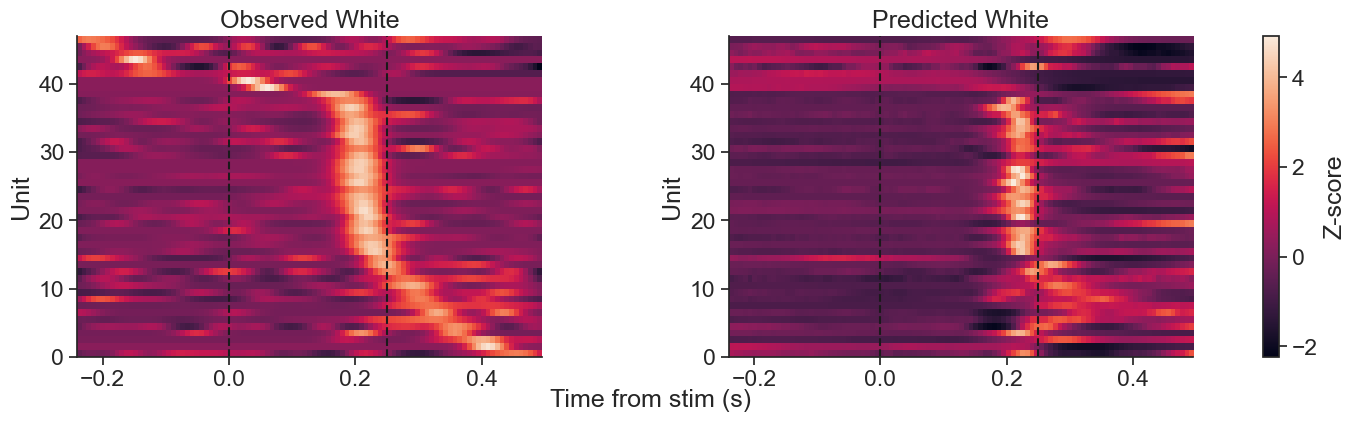

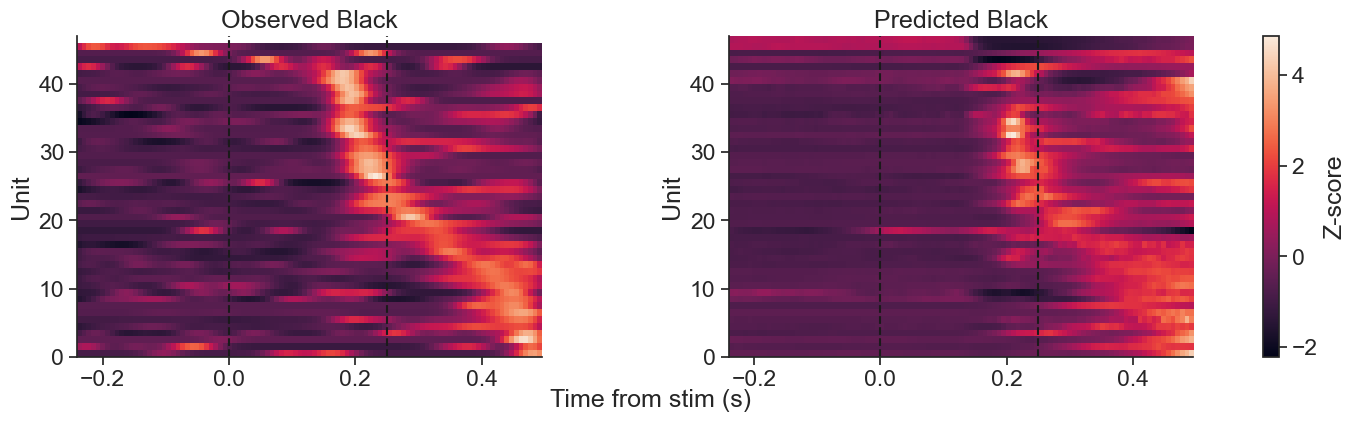

In [82]:
plot_zscores(dic_test, dic_pred)

In our case, the predicted activity lacks much of the temporal structure seen in the observed data. This suggests that the model, which currently only includes stimulus history (black/white flash for a 250ms duration filter), may be too simple. What could we try to improve this model a little bit? 

## Adding coupling terms as a new predictor
We can try extending the model in order to improve its performance. There are many ways one can do this: the iterative refinement and improvement of your model is an important part of the scientific process! In this tutorial, we’ll discuss one such extension, but you’re encouraged to try others.

Now, we'll extend the model by adding coupling terms—that is, including the activity of other neurons as predictors—to account for shared variability within the network. 

We start by creating a new additive basis, which will now include the spike counts of all the population.

In [58]:
# New basis
basis_coupling = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=8, window_size=window_len, label="spike_history"
)

basis = basis_white + basis_black + basis_coupling

X_coupling_train = basis.compute_features(
    predictors_train["white"], 
    predictors_train["black"], 
    units_counts_train
)
X_coupling_test = basis.compute_features(
    predictors_test["white"], 
    predictors_test["black"], 
    units_counts_test
)

We initialize a new ```PopulationGLM``` object

In [59]:
# Fit with new basis as predictor
# Fitting pop model
regularizer_strength = 0.005 # Where did this come from???? We are not running this again but i also dont know how to run cross validation for a population????? and dont know how to conduct a coupling filter with single unit fit.

model_coupling = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = regularizer_strength,
    solver_name="LBFGS"
)


And we fit!

In [60]:
model_coupling.fit(X_coupling_train,units_counts_train)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.005,
    solver_name='LBFGS'
)

### Assess coupling GLM Population performance: heatmap

The same way as before, we can obtain the predictions using ```predict```

In [61]:
predicted = model_coupling.predict(X_coupling_test)/ bin_sz

We can center unit's activity around stimuli presentation with ```compute_perievent_continuous```

In [62]:
# Calculate perievent for predicted
peri_white_pred = nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax=(window_size)
)  

peri_black_pred =  nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_black.start+.50),
    minmax=(window_size)
)  

Create our dictionaries of z-scored mean activity

In [63]:
dic_test, dic_pred = create_zscore_dic(
    peri_white_test,
    peri_black_test,
    peri_white_pred,
    peri_black_pred
)

And plot our heat map!

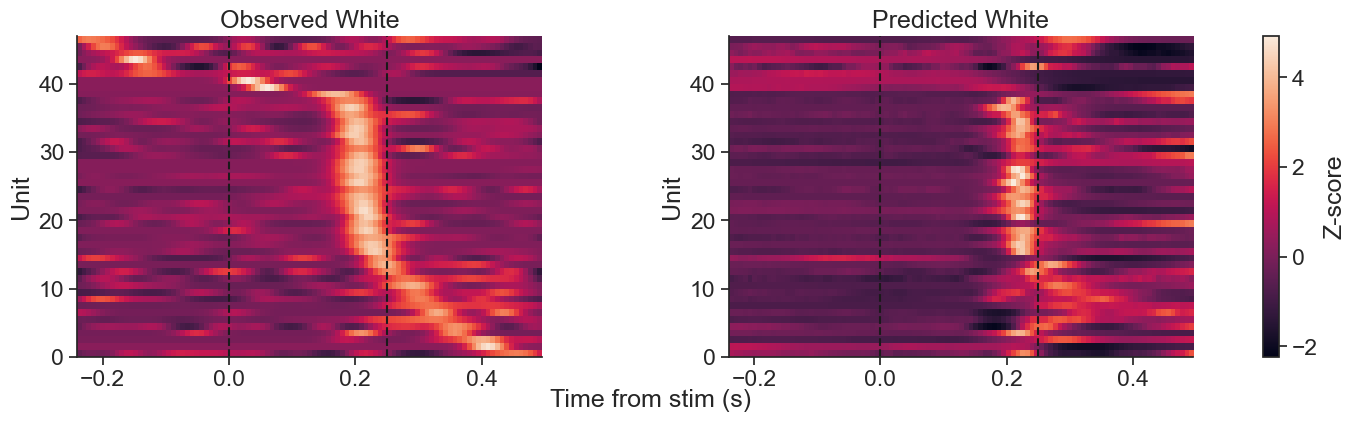

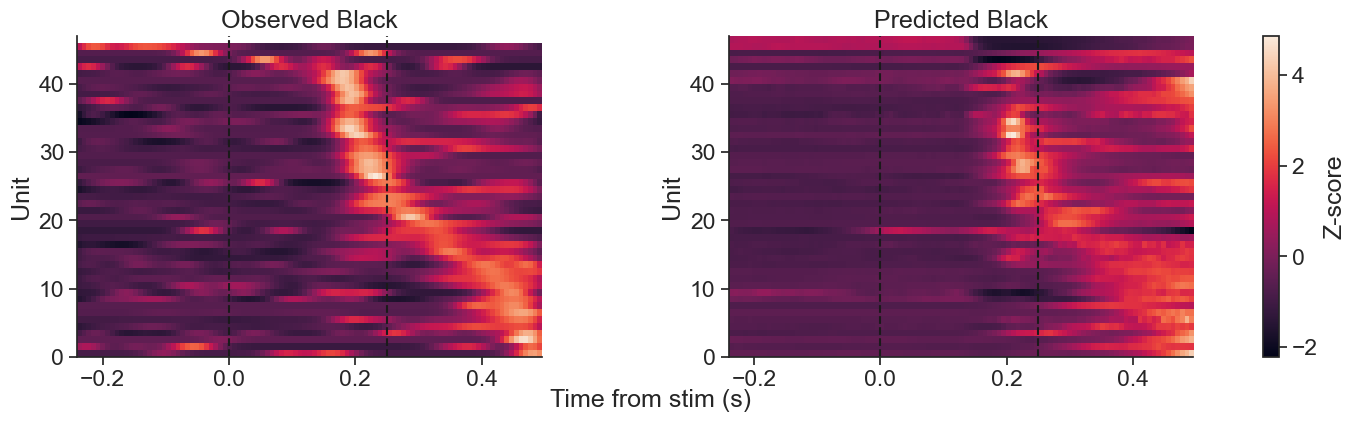

In [64]:
plot_zscores(dic_test, dic_pred)

We can see that the average peak activity is much better captured by this new model! This suggests that using time-history predictors for just these two stimuli presentation may not be sufficient for modeling neuronal activity. This makes a lot of sense! LNP models are very simple, and only having two sets of predictors is generally quite little. Our addition of coupling activity is now helping us account for non-stimuli derived variability, which improves the fit significantly and is not to be ignored!

## Evaluate model performance quantitatively

Comparing the two models by examining their predictions is important, but you may also want a number with which to evaluate and compare your models’ performance. As discussed earlier, the GLM optimizes log-likelihood to find the best-fitting weights, and we can calculate this number using its ```score``` method.

### Using Log-Likelihood

In [65]:
def evaluate_model(model, X, y, score_type = "log-likelihood"):
    score_pop = model.score(
        X, 
        y, 
        score_type= score_type,
    )
    score_unit = model.score(
        X, 
        y, 
        aggregate_sample_scores=lambda x:np.mean(x,axis=0), 
        score_type= score_type,
    )
    return score_pop, score_unit 

def evaluate_models_by_color(models, X_sets, y_sets, flashes_color, score_type = "log-likelihood"):
    '''
    Returns
    model base pop, model base unit, model hist pop, model hist unit
    '''
    models_list = []
    for model_name, model in models.items():
        X = X_sets[model_name].restrict(flashes_color)
        y = y_sets.restrict(flashes_color)
        models_list.append(evaluate_model(model, X, y, score_type))
    return models_list[0][0], models_list[0][1], models_list[1][0],models_list[1][1]

In [66]:
# Define model dictionary
models = {
    "stimuli": model_stimuli,
    "coupling": model_coupling
}

score_stimuli_pop, score_stimuli_unit = evaluate_model(
    models["stimuli"],
    X_test,
    units_counts_test,
)

score_coupling_pop, score_coupling_unit = evaluate_model(
    models["coupling"],
    X_coupling_test,
    units_counts_test,
)

(score_white_stimuli_pop, 
 score_white_stimuli_unit, 
 score_white_coupling_pop,
 score_white_coupling_unit) = evaluate_models_by_color(
    models,
    {"stimuli": X_test, 
    "coupling": X_coupling_test},
    units_counts_test,
    flashes_test_white
)

(score_black_stimuli_pop, 
 score_black_stimuli_unit, 
 score_black_coupling_pop,
 score_black_coupling_unit) = evaluate_models_by_color(
    models,
    {"stimuli": X_test, 
    "coupling": X_coupling_test},
    units_counts_test,
    flashes_test_black
)

In [67]:
def plot_scores(scores, labels, score_method):
    # Plot as bar chart
    plt.figure(figsize=(7, 4))
    bars = plt.bar(labels, scores, color="skyblue", edgecolor='black')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.001, 
                f"{height:.5f}", ha='center', va='bottom')

    plt.ylabel(f"{score_method}")
    plt.title("Model Scores by Condition")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

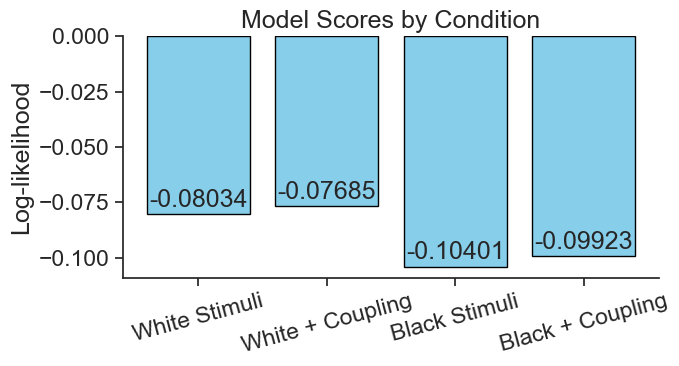

In [68]:
# Extract scalar values from single-element arrays
scores = [
    score_white_stimuli_pop,
    score_white_coupling_pop,
    score_black_stimuli_pop,
    score_black_coupling_pop
]

# Corresponding labels for each score
labels = [
    "White Stimuli",
    "White + Coupling",
    "Black Stimuli",
    "Black + Coupling"
]

plot_scores(
    scores,
    labels,
    "Log-likelihood"
)

### Using Pseudo-$R^2$ McFadden

This log-likelihood is un-normalized and thus doesn’t mean that much by itself, other than “higher=better”. When comparing alternative GLMs fit on the same dataset, whether that’s models using different regularizers and solvers or those using different predictors, comparing log-likelihoods is a reasonable thing to do.

Note that, because the log-likelihood is un-normalized, it should not be compared across datasets (because e.g., it won’t account for difference in noise levels). We provide the ability to compute the pseudo-$R^2$ for this purpose:

In [69]:
# Define model dictionary
models = {
    "stimuli": model_stimuli,
    "coupling": model_coupling
}

score_stimuli_pop, score_stimuli_unit = evaluate_model(
    models["stimuli"],
    X_test,
    units_counts_test,
)

score_coupling_pop, score_coupling_unit = evaluate_model(
    models["coupling"],
    X_coupling_test,
    units_counts_test,
    "pseudo-r2-McFadden"
)

(score_white_stimuli_pop, 
 score_white_stimuli_unit, 
 score_white_coupling_pop,
 score_white_coupling_unit) = evaluate_models_by_color(
    models,
    {"stimuli": X_test, 
    "coupling": X_coupling_test},
    units_counts_test,
    flashes_test_white,
    "pseudo-r2-McFadden"
)

(score_black_stimuli_pop, 
 score_black_stimuli_unit, 
 score_black_coupling_pop,
 score_black_coupling_unit) = evaluate_models_by_color(
    models,
    {"stimuli": X_test, 
    "coupling": X_coupling_test},
    units_counts_test,
    flashes_test_black,
    "pseudo-r2-McFadden"
)

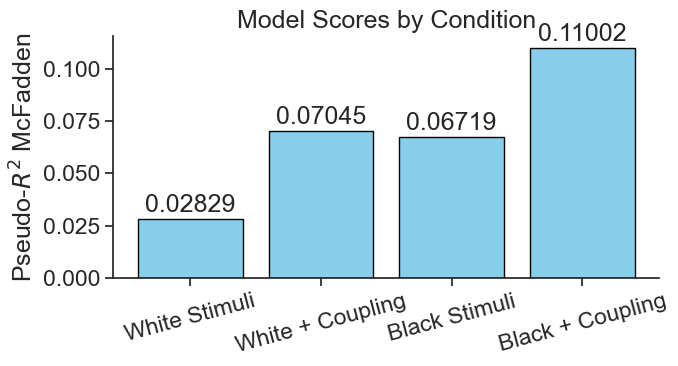

In [70]:
# Extract scalar values from single-element arrays
scores = [
    score_white_stimuli_pop,
    score_white_coupling_pop,
    score_black_stimuli_pop,
    score_black_coupling_pop
]

# Corresponding labels for each score
labels = [
    "White Stimuli",
    "White + Coupling",
    "Black Stimuli",
    "Black + Coupling"
]

plot_scores(
    scores,
    labels,
    "Pseudo-$R^2$ McFadden"
)

We can also see the individual scores for each unit!

In [71]:
def plot_unit_scores():
        # Combine all arrays into a list
    score_arrays = [
        score_white_stimuli_unit,
        score_white_coupling_unit,
        score_black_stimuli_unit,
        score_black_coupling_unit
    ]

    labels = ["White Stimuli", "White + Cupling", "Black Stimuli", "Black + Coupling"]
    num_conditions = len(score_arrays)
    num_units = len(score_white_stimuli_unit)

    # X positions for boxplots (centered)
    x_positions = np.arange(num_conditions)
    plt.figure(figsize=(17, 5))

    # Plot boxplots
    plt.boxplot(score_arrays, positions=x_positions, widths=0.5)

    # Scatter individual dots (jittered) and connect lines
    for unit_idx in range(num_units):
        unit_scores = [arr[unit_idx] for arr in score_arrays]
        x_jittered = x_positions + np.random.normal(scale=0.01, size=num_conditions)
        
        # Scatter dots
        plt.scatter(x_jittered, unit_scores, color="black", s=10, alpha=0.7)

        # Connect dots for this unit
        plt.plot(x_jittered, unit_scores, color="black", alpha=0.7, linewidth=1)

    # X-axis labels
    plt.xticks(x_positions, labels)
    plt.ylabel("Pseudo-$R^2$ McFadden Score")
    plt.title("Unit scores across models and conditions")
    plt.tight_layout()
    plt.show()

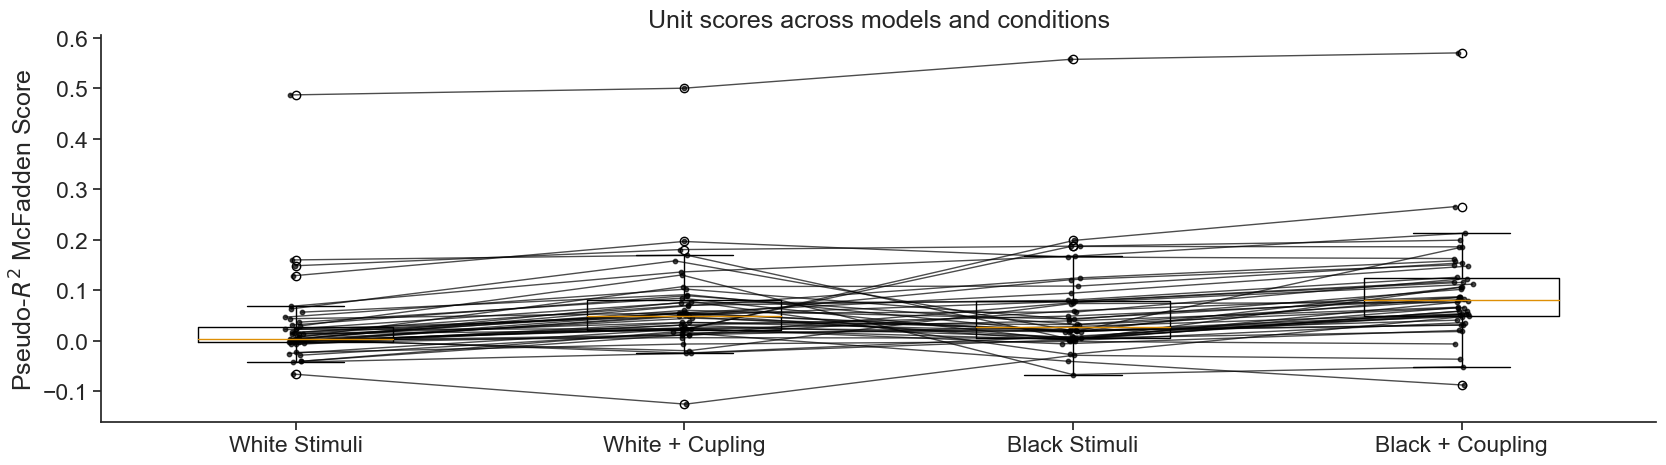

In [72]:
plot_unit_scores()

Admonition

Now we want to see which model has the best performance. When assesing this, it is important that we ask ourselves what is the most reasonable way to do it.

Usually, in linear regression, the $Rˆ2$ measure is used, which is interpreted as the proportion of explained variance by a given model:

$$
\begin{aligned}
R^2 = 1- \frac{\sum_i{(y_i - \hat{y})^2}}{\sum_i{(y_i - \mu)^2}}
\end{aligned}
$$

The numerator in this equation is the variance NOT explained by the model, while the denominator is the total variance of the model. For example, if a given model is perfect at predicting the mean but nothing else, then:

$$
\begin{aligned}
R^2 = 1- \frac{\sum_i{(y_i - \hat{y})^2}}{\sum_i{(y_i - \mu)^2}} = 1 - \frac{\sum_i{(y_i - \mu)^2}}{\sum_i{(y_i - \mu)^2}} = 1 - 1 = 0
\end{aligned}
$$

and the model explains very little of the variance.

Crucially, however, in GLMs, the variance has some characteristics that are incompatible with regular linear regression. In particular:
1. GLMs do not meet the homoscedasticity assumption necessary for linear regression (and $Rˆ2$ interpretation) to make sense. This assumption describes a situation in which the error term is the same across all samples; i.e. constant variance. In GLMs, the variance is not constant! In particular with LNP models, the variance is actually the same as the mean!
2. The $R^2$ captures the variance explained when there is a linear relationship between the observations and the predictor. However, in GLMs, the non-linearity sets a non-linear mapping between the predictors and the mean of the observations. Because of that, the variance explained interpretation does not hold either.




## References

Questions
- scores plot per unit looks awful
- is smoothing explanation okay?
- Is hankel matrix explanation + gif confusing?

To fix now:
- Complete quantitative evaluation texts
- Read all texts
- Add references/citations
- check all titles are uniform in terms of caps
- Make sure there are explanations in markdown for all steps
- Comment all functions
- Update requirements and check if passess tests

Optional:
- Add more resources
- Add estimated time of completion
- Add learning objectives
- plot peth one by one for output of models?
- Add self-reflection questions (ideas - limitations for this model?)
- plot basis dot coefficient for a neuron to see learned filter in action
- add single neuron plot for perievent predicted no smoothing

 
Optional if decide to show responsiveness & coupled filters:
- convolve coefficients with basis and sum that? - also, im doing something wrong with the plot. double check


## Other stuff I will prolly not use

### Interpreting the coefficients?
The learned model coefficients are in a 2D array of shape ```(n_predictors, n_neurons)```. This array concatenates the coefficients representing pairwise couplings along the first dimension. Using the ```split_by_feature``` method of the basis object, the coefficients can be reshaped into a 3D array of shape ```(n_neurons, n_basis_funcs, n_neurons```, where the first dimension corresponds to sender neurons, the second dimension contains the basis function coefficients, and the third dimension corresponds to receiver neurons.

Let's select the neurons for which the history filter was actually better!

In [73]:
# get the dictionary (1 key per basis component, here there is single basis component)
weights_dict = basis.split_by_feature(model_coupling.coef_, axis=0)

weights = weights_dict["spike_history"]

weights_sum = weights.sum(axis=1)

weights_sum.shape

(47, 47)

In [74]:
diff_white = score_white_coupling_unit - score_white_stimuli_unit
diff_black = score_black_coupling_unit -  score_black_stimuli_unit

mask_white = (diff_white > 0.05).astype(int)
mask_black = (diff_black > 0.05).astype(int)

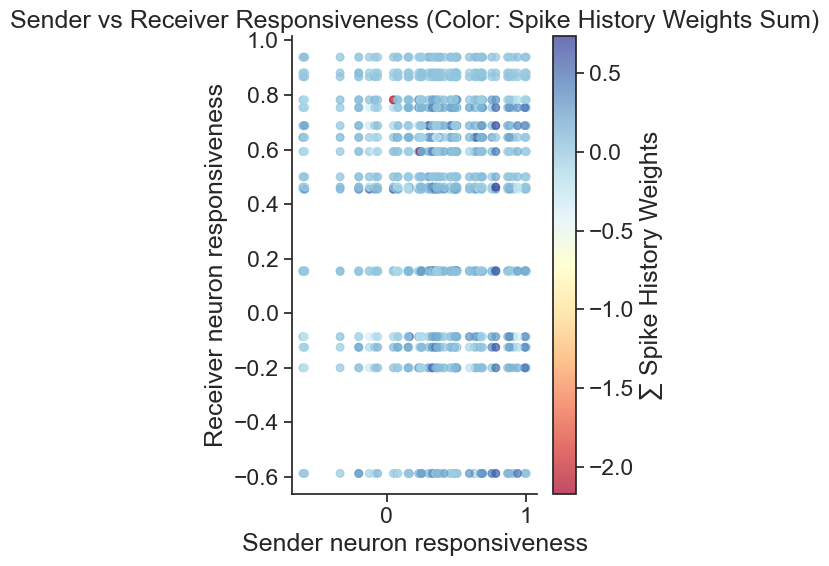

In [75]:
mask_bool = mask_white.astype(bool)  # ensure it's boolean

# Select only columns (i.e., select target neurons)
weights_selected = weights_sum[:, mask_bool]
weights_selected.shape


# Selected pairs
neuron_ids = list(units.index)  

mask_bool = mask_white.astype(bool)

# Apply mask to neuron_ids
masked_neuron_ids = [nid for nid, keep in zip(neuron_ids, mask_bool) if keep]

# Generate all pairs from masked neurons
pairs = [(s, r) for s, r in itertools.product(neuron_ids, masked_neuron_ids)]

pairs_ = [(s, r) for s, r in itertools.product(list(range(weights_selected.shape[0])),list(range(weights_selected.shape[1])))]

# Get responsiveness values
stimulus = "responsiveness_white"
x = [units[[s]][stimulus].values[0] for s, r in pairs]
y = [units[[r]][stimulus].values[0] for s, r in pairs]

idx_to_unit = list(units.index)
unit_to_idx = {unit: i for i, unit in enumerate(idx_to_unit)}

# Color: summed weights from spike history
colors = [weights_sum[s, r] for s, r in pairs_]

# Plot
plt.figure(figsize=(5, 6))
sc = plt.scatter(x, y, c=colors, cmap="RdYlBu", alpha=0.7, s=30)
plt.xlabel("Sender neuron responsiveness")
plt.ylabel("Receiver neuron responsiveness")
plt.title("Sender vs Receiver Responsiveness (Color: Spike History Weights Sum)")

# Colorbar
cbar = plt.colorbar(sc)
cbar.set_label("∑ Spike History Weights")

plt.tight_layout()
plt.show()

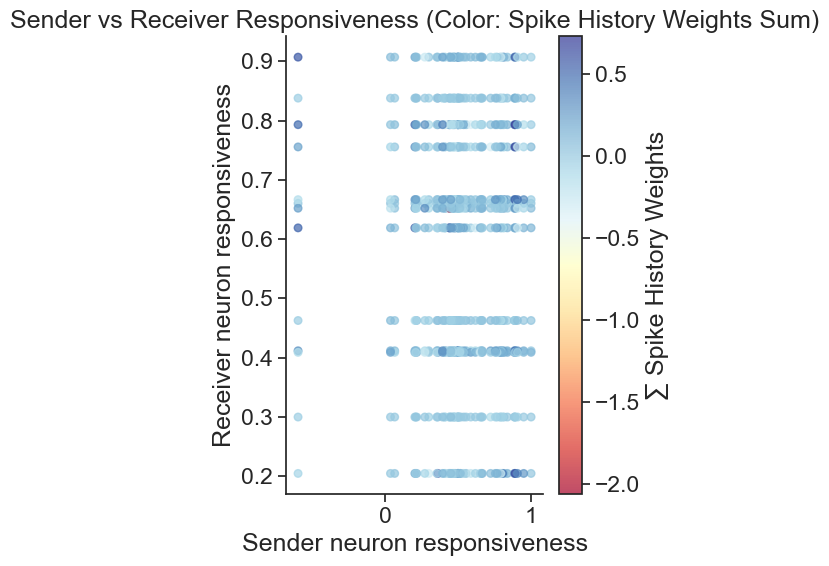

In [76]:
mask_bool = mask_black.astype(bool)  # ensure it's boolean

# Select only columns (i.e., select target neurons)
weights_selected = weights_sum[:, mask_bool]
weights_selected.shape


# Selected pairs
neuron_ids = list(units.index)  

mask_bool = mask_black.astype(bool)

# Apply mask to neuron_ids
masked_neuron_ids = [nid for nid, keep in zip(neuron_ids, mask_bool) if keep]

# Generate all pairs from masked neurons
pairs = [(s, r) for s, r in itertools.product(neuron_ids, masked_neuron_ids)]


pairs_ = [(s, r) for s, r in itertools.product(list(range(weights_selected.shape[0])),list(range(weights_selected.shape[1])))]

# Get responsiveness values
stimulus = "responsiveness_black"
x = [units[[s]][stimulus].values[0] for s, r in pairs]
y = [units[[r]][stimulus].values[0] for s, r in pairs]

idx_to_unit = list(units.index)
unit_to_idx = {unit: i for i, unit in enumerate(idx_to_unit)}

# Color: summed weights from spike history
colors = [weights_sum[s, r] for s, r in pairs_]

# Plot
plt.figure(figsize=(5, 6))
sc = plt.scatter(x, y, c=colors, cmap="RdYlBu", alpha=0.7, s=30)
plt.xlabel("Sender neuron responsiveness")
plt.ylabel("Receiver neuron responsiveness")
plt.title("Sender vs Receiver Responsiveness (Color: Spike History Weights Sum)")

# Colorbar
cbar = plt.colorbar(sc)
cbar.set_label("∑ Spike History Weights")

plt.tight_layout()
plt.show()

note on intercept:
(for the GLM object, this will always be 1, but it will differ for the PopulationGLM object!)

### Extra: fitting single neuron spiking activity

In [77]:
'''

# Fitting single unit
reg_strength = 0.005
models = np.empty((units_counts_train.shape[1]), dtype=object) # as many fits as units

predictions = np.empty((units_counts_test.shape[1]), dtype=object) # test timepoings x units
#num_units = units_counts_test.shape[1]
#predictions = {unit: None for unit in range(num_units)}

for unit in range(units_counts_test.shape[1]):
    # New basis
    spike_hist_bas = nmo.basis.RaisedCosineLogConv(
        n_basis_funcs=8, window_size=window_len, label="spike_history"
    )

    basis = additive_basis + spike_hist_bas

    X_coupling_train = basis.compute_features(
        predictors_train["white"], 
        predictors_train["black"], 
        units_counts_train[:,unit]
    )
    X_coupling_test = basis.compute_features(
        predictors_test["white"], 
        predictors_test["black"], 
        units_counts_test[:,unit]
    )
    model = nmo.glm.GLM(
        regularizer = "Ridge",
        regularizer_strength = reg_strength,
        solver_name="LBFGS"
    )
    
    model.fit(X_coupling_train,units_counts_train[:,unit])
    model.score(X_coupling_test,units_counts_test[:,unit])

    predictions[unit] = model.predict(X_coupling_test)/ bin_sz
    models[unit] = model

n_features =18
n_neurons = units_counts_train.shape[1]
coef_ = np.zeros((n_features, n_neurons))
intercept_ = np.zeros(n_neurons)

for neuron in range(units_counts_test.shape[1]):
    coef_[:,neuron] = models[neuron].coef_
    intercept_[neuron] = models[neuron].intercept_[0]

pop_model_hist = nmo.glm.PopulationGLM()

pop_model_hist.coef_ = coef_
pop_model_hist.intercept_ = intercept_

# Assuming predictions is of shape (47,)
# and each predictions[i].as_array() is (120000,)
arr_list = [predictions[i].as_array() for i in range(len(predictions))]

# Shape: (120000, 47)
pred_arr = np.column_stack(arr_list)

tsframe = nap.TsdFrame(t = units_counts_test.t, d = pred_arr)
tsframe

predicted = tsframe

# Calculate perievent for predicted
peri_white_pred = nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax=(window_size)
)  

peri_black_pred =  nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_black.start+.50),
    minmax=(window_size)
)  

dic_test, dic_pred = create_zscore_dic(
    peri_white_test,
    peri_black_test,
    peri_white_pred,
    peri_black_pred
)

plot_zscores(dic_test, dic_pred)
'''

'\n\n# Fitting single unit\nreg_strength = 0.005\nmodels = np.empty((units_counts_train.shape[1]), dtype=object) # as many fits as units\n\npredictions = np.empty((units_counts_test.shape[1]), dtype=object) # test timepoings x units\n#num_units = units_counts_test.shape[1]\n#predictions = {unit: None for unit in range(num_units)}\n\nfor unit in range(units_counts_test.shape[1]):\n    # New basis\n    spike_hist_bas = nmo.basis.RaisedCosineLogConv(\n        n_basis_funcs=8, window_size=window_len, label="spike_history"\n    )\n\n    basis = additive_basis + spike_hist_bas\n\n    X_coupling_train = basis.compute_features(\n        predictors_train["white"], \n        predictors_train["black"], \n        units_counts_train[:,unit]\n    )\n    X_coupling_test = basis.compute_features(\n        predictors_test["white"], \n        predictors_test["black"], \n        units_counts_test[:,unit]\n    )\n    model = nmo.glm.GLM(\n        regularizer = "Ridge",\n        regularizer_strength = reg_

Not as good as coupling filter!

:::{admonition} This is a different regularizer_strenght value - Where did that come from?
:class: info
:class: dropdown

We conducted cross validation again to obtain the regularization strength for this new model. Adding extra parameters increases the risk of overfitting, so getting a new regularization_strength to account for that makes sense.

```
spike_hist_bas = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=8, window_size=window_len, label="spike_history"
)

basis = additive_basis + spike_hist_bas

X_hist_train = basis.compute_features(
        predictors_train["white"], 
        predictors_train["black"], 
        u_counts_train
    )
X_hist_test = basis.compute_features(
    predictors_test["white"], 
    predictors_test["black"], 
    u_counts_test
)
model = nmo.glm.GLM(
    regularizer = "Ridge",
    regularizer_strength = 0.0001,
    solver_name="LBFGS"
)
# Create parameter grid
param_grid = {
    "regularizer_strength" : 
    np.geomspace(10**-9, 10, 10)
}

# Instantiate the grid search object
grid_search = GridSearchCV(
    model,param_grid, 
    cv=5
    )

# Run grid search
grid_search.fit(X_hist_train, u_counts_train)

# Print optimal parameter
print(grid_search.best_estimator_.regularizer_strength)
>>> 0.004641588833612782
```
::: 

:::{admonition} How can PopulationGLM be equivalent but faster?
bla
:::

add an admonition on why there is no prediction prior to the presentation of stimulus
admonition
taking an extra window because of the convolution thingy

Maybe not include: We will also show how, if you have recordings from a large population of neurons simultaneously, you can build connections between the neurons into the GLM in the form of coupling filters. This can help answer the degree to which activity is driven primarily by the input X, or by network influences in the population.